In [1]:
from HeaderP import *

In [698]:
def log_prior(params):
    m = params[0]
    return -1.5 * np.log(1 + m*m)

def log_marg_prob_scatter(params, S, yn, xn):
    m, b, log_lambda = params
    v = np.array([-m, 1.0])

    # Enforce the log-uniform prior on lambda. 
    if not -5.0 < log_lambda < 5.0:
        return -np.inf

    # Compute \Sigma^2 and \Delta.
    lamd = np.exp(log_lambda)
    Lambda = np.zeros((2,2))
    Lambda[0,0], Lambda[0,1], Lambda[1,0], Lambda[1,1] =  m**2, -m, -m, 1
    Lambda = Lambda * lamd**2/(1+m**2)
    Sigma2 = np.dot(np.dot(S+Lambda, v), v)
    Delta = m * xn + b - yn

    # Compute the log likelihood up to a constant.
    ll = -0.5 * np.sum(Delta**2 / Sigma2 + np.log(Sigma2))
    return ll + log_prior(params)

import emcee

def monoage(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5]):
    colors = getcolor(range(len(agebin)+1))
    plt.figure(figsize=(20,8))
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        r_sing = r_sing[m2]
        feh_sing = feh_sing[m2]
        
        r_ave, feh_ave = movingMed_time(r_sing, feh_sing, 1, 0.1)
        #feh_ave = gaussian_filter(feh_ave, 4)
        """if agebin[i]==12.:
            plt.plot(r_sing, feh_sing,'.', color=colors[i], markersize=1)"""
        plt.plot(r_ave, feh_ave, color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.grid(color='grey', linestyle='-', linewidth=1)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)

def getscatt_bay(feh, r, age, feh_err, r_err, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    
    nwalkers=64
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    scatters_err = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    feherr = feh_err[m]
    rerr = r_err[m]
    
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        feh_err_sing = feherr[m]
        r_err_sing = rerr[m]
        
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                #print(agebin[i], rbins[j], sum(m))
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                feh_err_sing_2 = feh_err_sing[m]
                r_err_sing_2 = r_err_sing[m]
        
                S = np.zeros((len(feh_sing_2),2,2))
                for k in range(len(feh_sing_2)):
                    S[k,0,0] = r_err_sing_2[k]**2
                    S[k,1,1] = feh_err_sing_2[k]**2
                print(agebin[i], rbins[j], len(feh_sing_2))
                z = np.polyfit(r_err_sing_2,feh_sing_2,1)
                sampler_scatter = emcee.EnsembleSampler(nwalkers, 3, log_marg_prob_scatter, args=(S, feh_sing_2, r_sing_2))
                p0 = np.array([z[0], z[1], np.log(0.03)])
                p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
                pos, _, _ = sampler_scatter.run_mcmc(p0, 1000, progress=True)
                sampler_scatter.reset()
                sampler_scatter.run_mcmc(pos, 6000, progress=True)
                samples_scatter = sampler_scatter.flatchain

                """# m
                mcmc = np.percentile(samples_scatter[:, 0], [16, 50, 84])
                q = np.diff(mcmc)
                hi_m[i,0], hi_m[i,1], hi_m[i,2] = mcmc[1], q[0], q[1]

                # b
                mcmc = np.percentile(samples_scatter[:, 1], [16, 50, 84])
                q = np.diff(mcmc)
                hi_b[i,0], hi_b[i,1], hi_b[i,2] = mcmc[1], q[0], q[1]"""

                # dispersion
                mcmc = np.percentile(samples_scatter[:, 2], [16, 50, 84])
                q = np.diff(mcmc)
                scatters[i,j], dishi, dislow = mcmc[1], q[0], q[1]
                scatters_err[i,j] = np.mean(abs(dishi)+abs(dislow))

                
    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters, scatters_err


def getscatt(feh, r, age, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    if len(feherr)>0:
            feherr = feherr[m]
    
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        if len(feherr)>0:
            feh_err_sing = feherr[m]
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                p = fitpoints(r_sing_2, feh_sing_2) 
                scatters[i,j] = np.std(feh_sing_2-p(r_sing_2))

                if len(feherr)>0:
                    feh_err_sing_2 = feh_err_sing[m]
                    scatters[i,j] = np.sqrt(scatters[i,j]**2-np.mean(feh_err_sing_2)**2)

    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters
    
def monoage_line(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[],plotlegend=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    plt.figure(figsize=(20,8))
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] = np.std(feh_sing[m2]-p(r_sing[m2]))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        plt.plot(r_sing[m2], p(r_sing[m2]), color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    if plotlegend:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter
    
def getcolor(vrange, cmap=plt.cm.get_cmap('plasma')):
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    #print([cmap(norm(i)) for i in vrange])
    return [cmap(norm(i)) for i in vrange]


def avr(age, r, vz, rbin=np.linspace(6,12,4), agebin=np.linspace(0,14,10)):
    colors = getcolor(range(len(rbin)+1))
    avrs = np.zeros((len(rbin)-1, len(agebin)-1))
    for i in trange(len(rbin)-1):
        m = (r>rbin[i])&(r<rbin[i+1])
        age_r, r_r, vz_r = age[m], r[m], vz[m]
        for j in range(len(agebin)-1):
            m2 = (age_r>agebin[j])&(age_r<agebin[j+1])
            if sum(m2)<10:
                avrs[i,j]=np.nan
            else:
                vz_r_age = vz_r[m2]
                avrs[i,j] = 1.5*sum(abs(vz_r_age-np.median(vz_r_age)))/sum(m2)
    return (agebin[:-1]+agebin[1:])/2, (rbin[:-1]+rbin[1:])/2, avrs
    

# Check simiulation with a bar

In [699]:
#simNo='6_96e11'
simNo='2_79e12'
#simNo='7_55e11'
#z='0'
#z='0_097' 
#z='0_255'
z='0'
# app-center passage
#z='0_25' 
#z='0_2' 
#z='0_195' 
#z='0_19' 
#z='0_1' 
# peri-center passage
#z='0_34' 
#z='0_35' 
#z='0_36' 
Rcut=True
select=False
Rcut_thread=30
zcut_thread=5

In [701]:
if simNo=='data':
    data=pd.read_pickle('../SecondYear/CannonDR16_cut.pkl')
    data['z_today']=data['z']
    data['x_today']=data['X']
    data['y_today']=data['Y']
    data['feh_scale']=data['M_H']
    data['ofe_scale']=data['O_FE']
    data['age']=data['Age']
elif select:
    data=pd.read_pickle('Data/Buck_g'+simNo+'_apogee_selec.pkl')
    data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
    data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
    scale_fe=0.250019907951355/np.std(data['feh'])
    scale_o=0.10861970484256744/np.std(data['ofe'])
    data['feh_scale']=data['feh']*scale_fe-0.0906638577580452-np.mean(data['feh'])
    data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-np.mean(data['ofe'])
elif not select:
    if z=='0':
        data=pd.read_pickle('../SimulationData/Data/Buck_g'+simNo+'.pkl')
    else:
        data=pd.read_pickle('../SimulationData/Data/Buck_g'+simNo+'_z'+z+'.pkl')
        try:
            data['x_today']=data['x']
            data['y_today']=data['y']
            data['z_today']=data['z']
        except:
            print(np.shape(data['x_today']))
        
    data['R_bir']=np.sqrt((data['x_birth'])**2+data['y_birth']**2)
    data['R']=np.sqrt((data['x_today'])**2+data['y_today']**2)
    scale_fe=0.250019907951355/np.std(data['feh'])
    scale_o=0.10861970484256744/np.std(data['ofe'])
    data['feh_scale']=data['feh']*scale_fe-0.0906638577580452-np.mean(data['feh'])
    data['ofe_scale']=data['ofe']*scale_o+0.08182460814714432-np.mean(data['ofe'])
    if Rcut:
        data=data.loc[data['R_bir']<Rcut_thread].reset_index(drop=True)
        data=data.loc[abs(data['z_birth'])<zcut_thread].reset_index(drop=True)
        
vscale = 240/340
rscale = 3.5/5.6
data['vx'] = data['vx']*vscale
data['vy'] = data['vy']*vscale
data['vz'] = data['vz']*vscale

data['R'] = data['R']*rscale
data['R_bir'] = data['R_bir']*rscale
data['x'] = data['x']*rscale
data['y'] = data['y']*rscale
data['z'] = data['z']*rscale

data['Jr'] = data['Jz']*rscale*rscale
data['Jphi'] = data['Jphi']*rscale*rscale
data['Jz'] = data['Jz']*rscale*rscale

data.columns

Index(['vx_birth', 'vy_today', 'vz_today', 'z_today', 'vy_birth', 'ofe',
       'iords', 'vx_today', 'x_today', 'feh', 'x_birth', 'y_birth', 'vz_birth',
       'mass', 'y_today', 'oxh', 'z_birth', 'age', 'iord', 'vx', 'vy', 'vz',
       'x', 'y', 'z', 'Jr', 'Jphi', 'Jz', 'R', 'R_bir', 'feh_scale',
       'ofe_scale'],
      dtype='object')

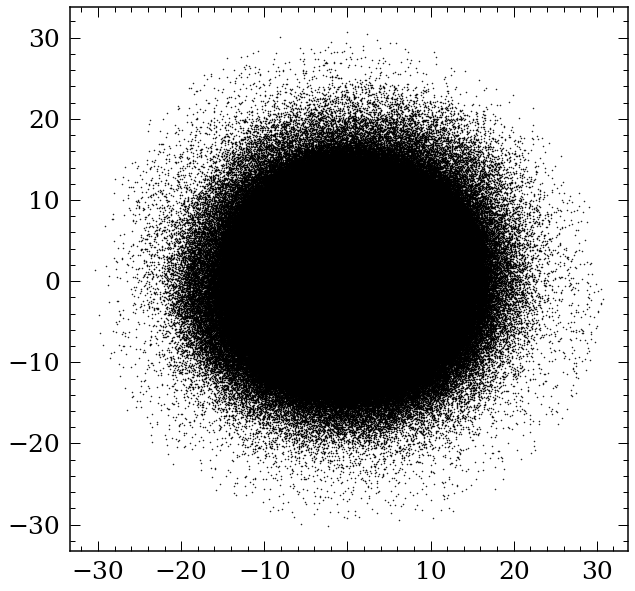

In [765]:
plt.plot(data['x'], data['y'], 'k.', markersize=1)

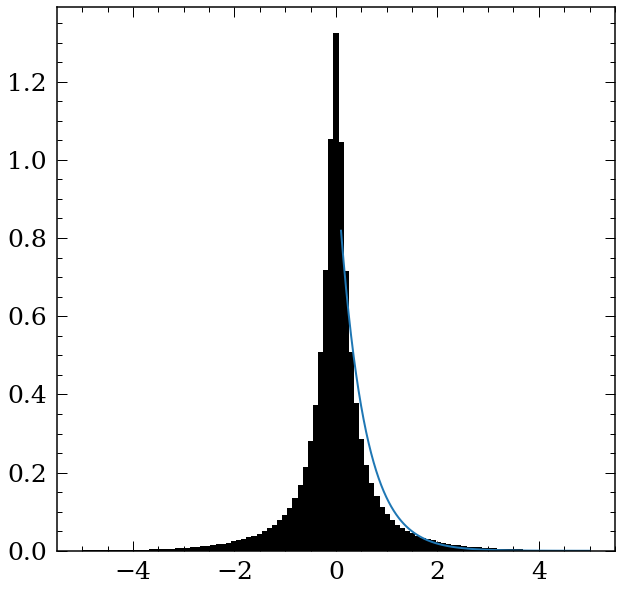

In [808]:
plt.hist(data['z'], bins=np.linspace(-5,5,100), color='k', density=1);
plt.plot(np.linspace(0.1,5,100), np.exp(-np.linspace(0.1,5,100)/0.5))

Text(0, 0.5, '[α/Fe]')

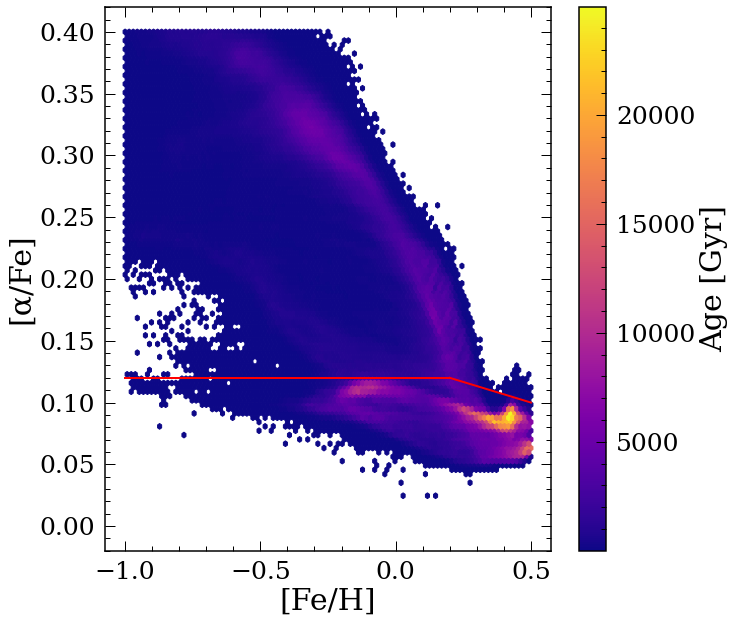

In [702]:
plt.hexbin(data['feh'], data['ofe'], extent=(-1,0.5,0,0.4), cmap='plasma',
          mincnt=1)

plt.plot([-1,0.2], [0.12,0.12], 'r-')
plt.plot([0.2,0.5], [0.12,0.1], 'r-')

def hilow_disk(feh, alpha):
    hi_low = np.zeros(len(feh))
    
    m = feh<0.2
    hi_low[m] = alpha[m]>0.12
    
    p = fitpoints([0.2,0.5], [0.12,0.1])
    hi_low[~m] = alpha[~m]>p(feh[~m])
    
    return hi_low

data['hi_low'] = hilow_disk(data['feh'].values, data['ofe'].values)
#sub_low = data.loc[data['hi_low']==1]
#plt.plot(sub_low['feh'], sub_low['ofe'], 'r.')

cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')



100%|██████████| 49/49 [01:05<00:00,  1.34s/it]


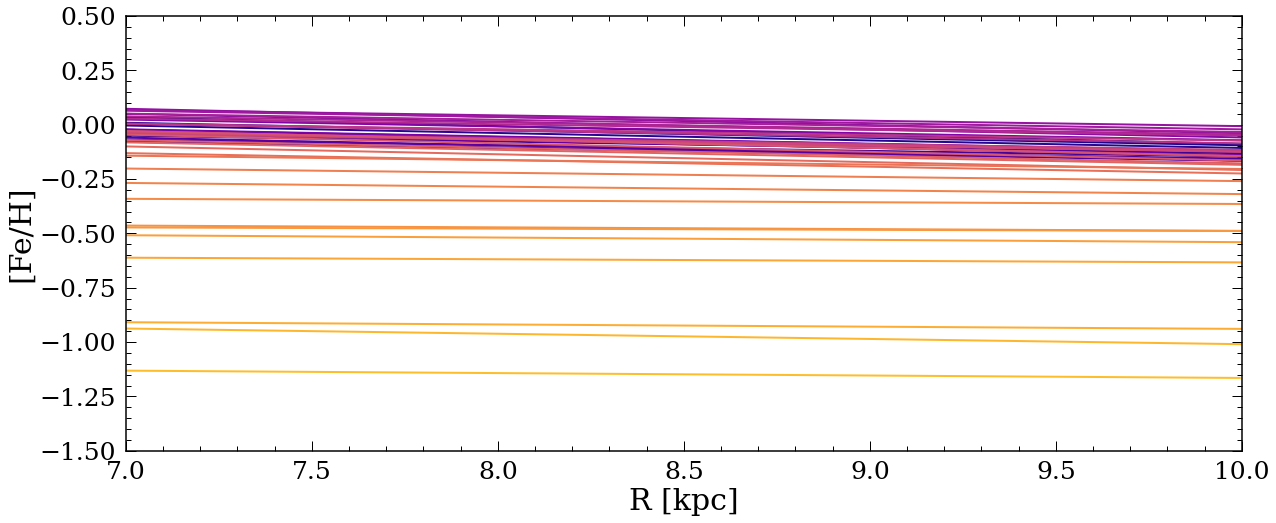

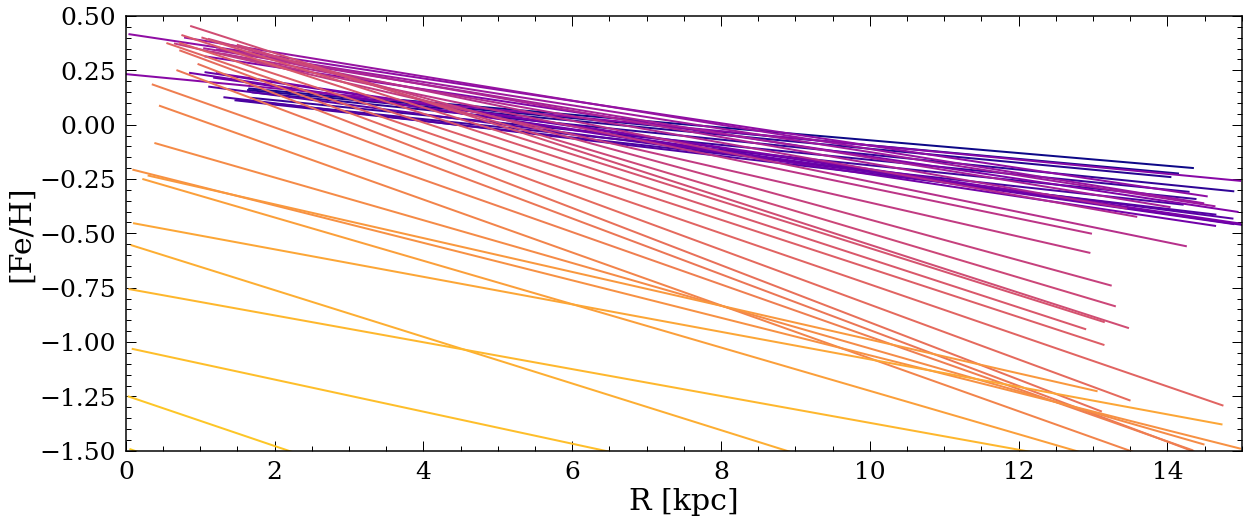

In [729]:
import warnings
warnings.filterwarnings('ignore')


m = (data['R']>7)&(data['R']<10)
ages, slopes, fehscatter = monoage_line(data['feh'].values[m], 
                                        data['R'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,14,50),
                                        xlims=[7,10],plotlegend=False)

ages, slopes_rbir, fehscatter_rbir = monoage_line(data['feh'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,14,50),
                                        xlims=[0,15],plotlegend=False)


In [730]:
df = pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir'])


In [731]:
m2pattern = pd.read_pickle('ISM_slope_g279e12.pkl')
merger = pd.read_pickle('./g2.79e12_merger_Lucy.dat')

In [732]:
mergertimes = 13.8-merger['time']
mergervir = merger['vir_ratio']

disktime = np.array(13.8-m2pattern['time'])
disksize = np.array(m2pattern['half_mass_l2'])

agebin=np.linspace(0,14,50)
mass_ave = np.zeros(len(agebin)-1)
disksize_ave = np.zeros(len(agebin)-1)

agebin=np.linspace(0,14,50)
for i in range(len(agebin)-1):
    m = (mergertimes>agebin[i])&(mergertimes<agebin[i+1])
    m2 = (disktime>agebin[i])&(disktime<agebin[i+1])
    #mass_ave[i] = sum(mergervir[m])
    if sum(m) == 0:
        mass_ave[i] = 0
    else:
        mass_ave[i] = sum(mergervir[m])/sum(m)
        
        
    if sum(m2) == 0:
        disksize_ave[i] = np.nan
    else:
        disksize_ave[i] = np.mean(disksize[m2])
        
diskprop = pd.DataFrame(np.array(((agebin[1:]+agebin[:-1])/2, disksize_ave)).T,
                       columns=['age', 'disksize'])

49


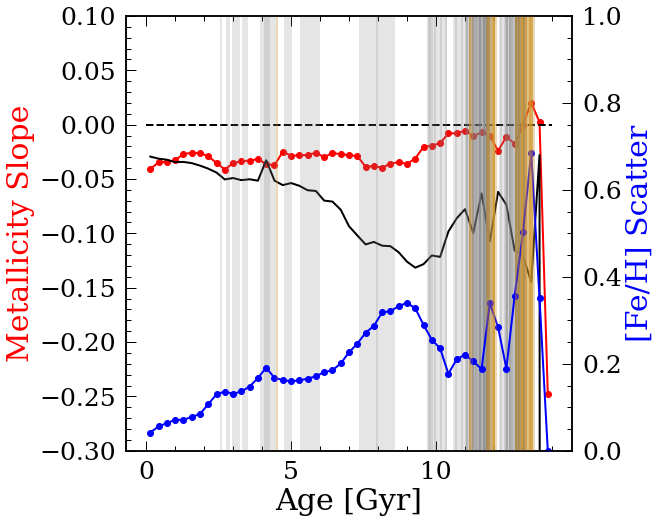

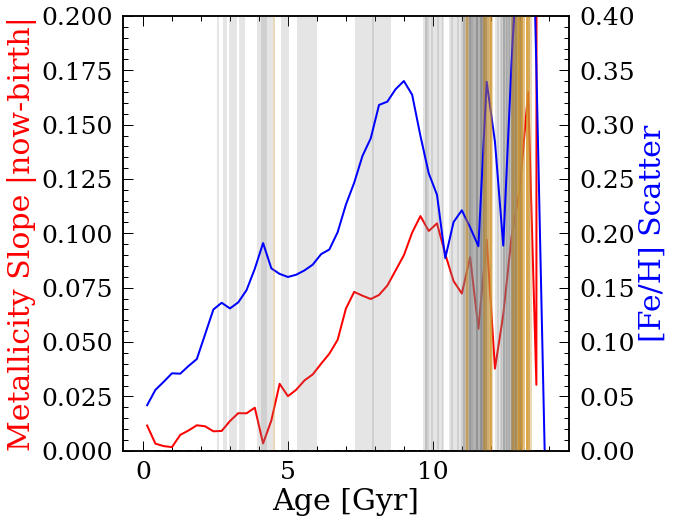

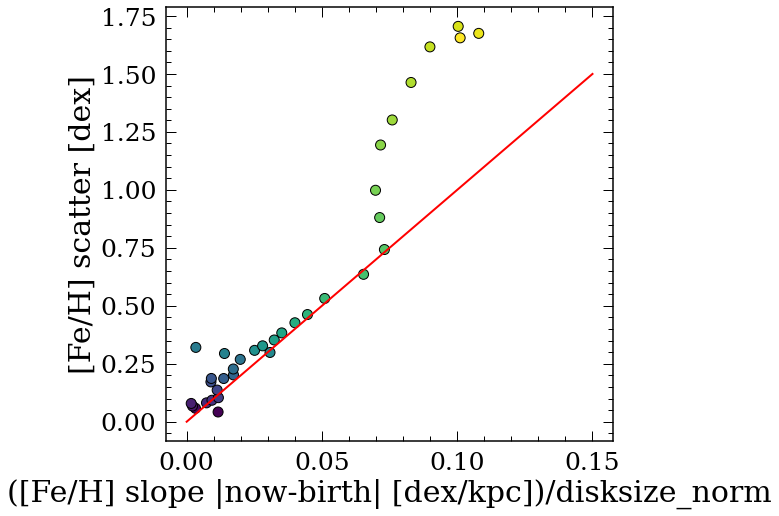

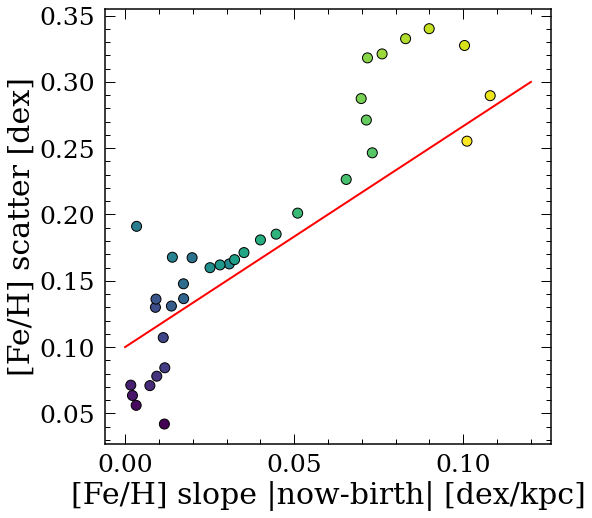

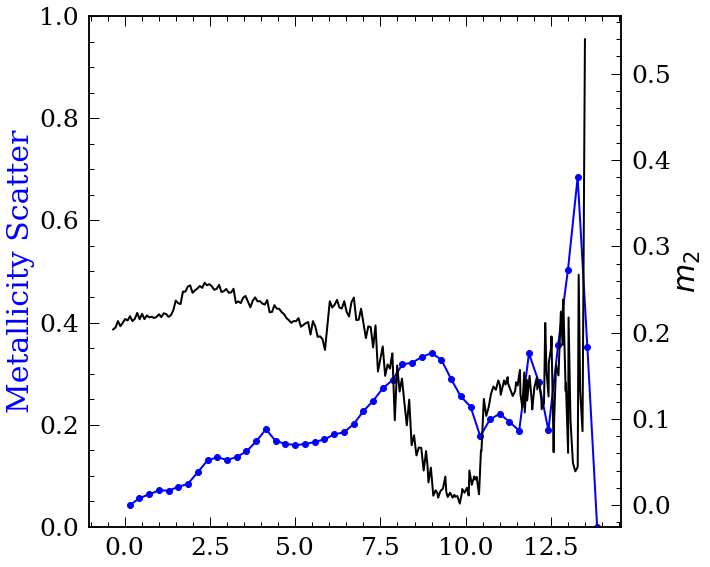

In [733]:

#df = pd.read_csv('g2.79e12_fehscatter.csv')
df = pd.merge(df, diskprop, left_on='age', right_on='age', how='inner')
df['disksize_norm'] = df['disksize']/max(df['disksize'])
print(len(df))

plt.figure(figsize=(8,8))
plt.plot(df['age'], df['slopes'], 'r-o')
plt.plot(df['age'], df['slopes_rbir'], 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('Metallicity Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.3, 0.1])

plt.twinx()
plt.plot(df['age'], df['fehscatter'], 'b-o')
m = mergervir>0.1
plt.vlines(mergertimes, ymin=0, ymax=1, color='grey', alpha=0.2, zorder=1)
plt.vlines(mergertimes[m], ymin=0, ymax=1, color='orange', alpha=0.2, zorder=2)
plt.ylim([0,1])
#plt.yscale('log')
plt.ylabel('[Fe/H] Scatter', color='b',zorder=5)



plt.figure(figsize=(8,8))
plt.plot(df['age'], abs(df['slopes_rbir']-df['slopes']), 'r-')
plt.xlabel('Age [Gyr]')
plt.ylabel('Metallicity Slope |now-birth|', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([0, 0.2])

plt.twinx()
plt.plot(df['age'], df['fehscatter'], 'b-')
m = mergervir>0.1
plt.vlines(mergertimes, ymin=0, ymax=1, color='grey', alpha=0.2, zorder=1)
plt.vlines(mergertimes[m], ymin=0, ymax=1, color='orange', alpha=0.2, zorder=2)
plt.ylim([0,0.4])
#plt.yscale('log')
plt.ylabel('[Fe/H] Scatter', color='b',zorder=5)


plt.figure(figsize=(8,8))
m = df['age']<10
plt.scatter(abs(df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m]/(df['disksize_norm'][m]), 
           c=df['age'][m], s=100, edgecolor='k')
plt.xlabel('([Fe/H] slope |now-birth| [dex/kpc])/disksize_norm')
plt.ylabel('[Fe/H] scatter [dex]')
plt.plot([0,0.15], [0,1.5], 'r-')


plt.figure(figsize=(8,8))
m = df['age']<10
plt.scatter(abs(df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m], 
           c=df['age'][m], s=100, edgecolor='k')
plt.xlabel('[Fe/H] slope |now-birth| [dex/kpc]')
plt.ylabel('[Fe/H] scatter [dex]')
plt.plot([0,0.12], [0.1,0.3], 'r-')



plt.figure(figsize=(10,8))
p = fitpoints(df['age'], df['fehscatter'])
plt.plot(df['age'], df['fehscatter'], 'b-o')
plt.ylabel('Metallicity Scatter', color='b',zorder=10)
plt.ylim([0,1])
plt.twinx()
plt.plot(13.8-m2pattern['time'], m2pattern['m2'], 'k-')
plt.ylabel('$m_2$', color='k')
plt.xlabel('Age [Gyr]')
plt.tight_layout()

#plt.figure(figsize=(10,8))
#plt.plot(fehscatter-p(ages), mass_ave, 'ko')

## cut out some z=0 star

100%|██████████| 49/49 [00:54<00:00,  1.11s/it]


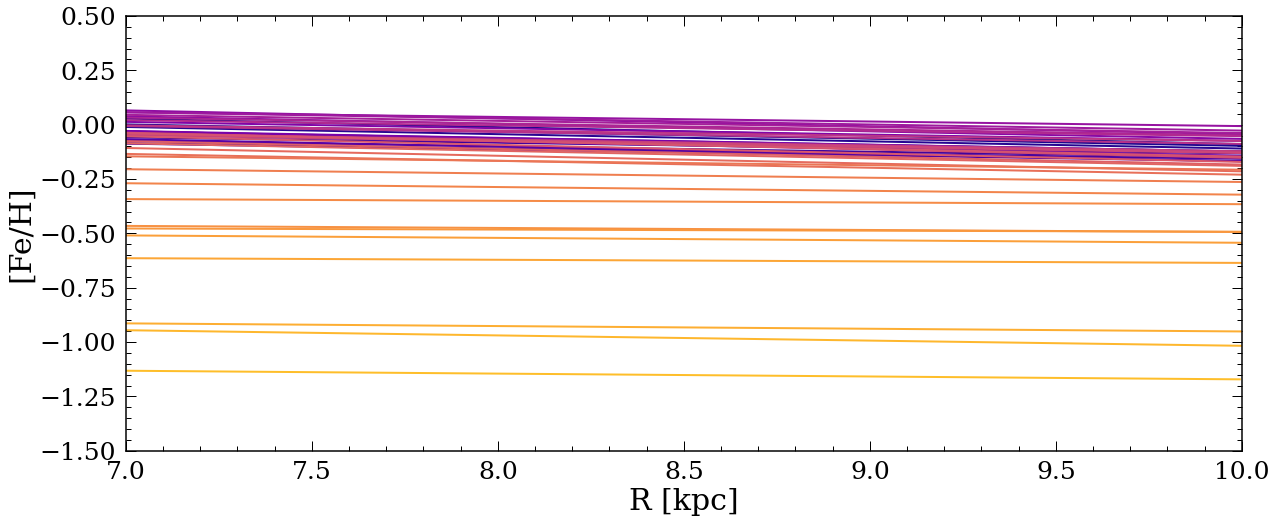

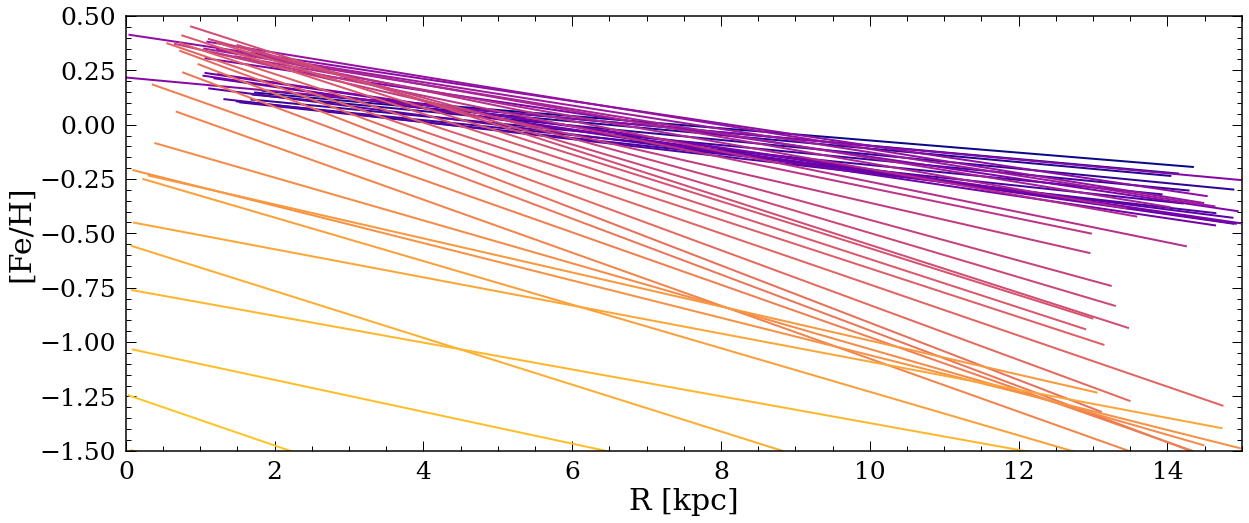

In [734]:
import warnings
warnings.filterwarnings('ignore')


m = (data['R']>7)&(data['R']<10)
m = m&(abs(data['z'])>0.2)
ages, slopes, fehscatter = monoage_line(data['feh'].values[m], 
                                        data['R'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,14,50),
                                        xlims=[7,10],plotlegend=False)

ages, slopes_rbir, fehscatter_rbir = monoage_line(data['feh'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,14,50),
                                        xlims=[0,15],plotlegend=False)



44


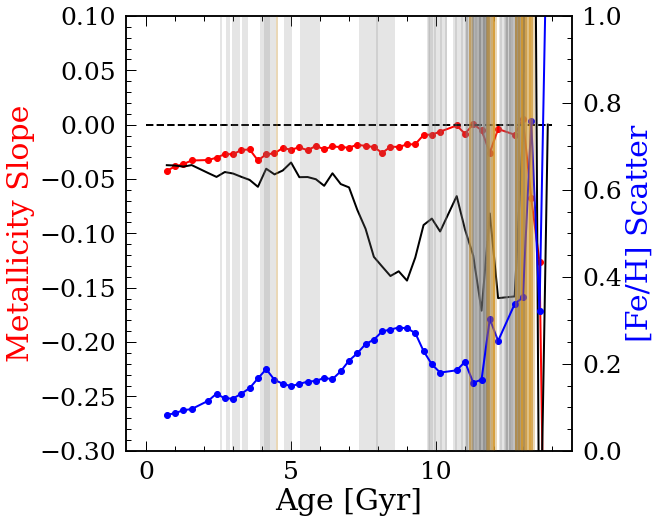

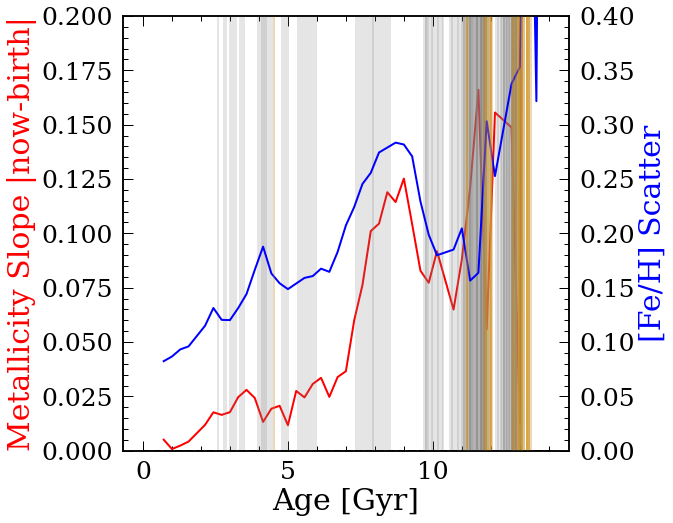

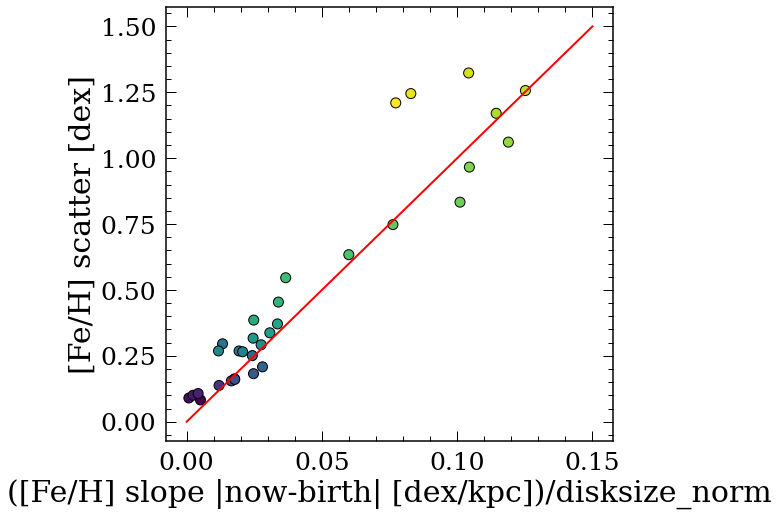

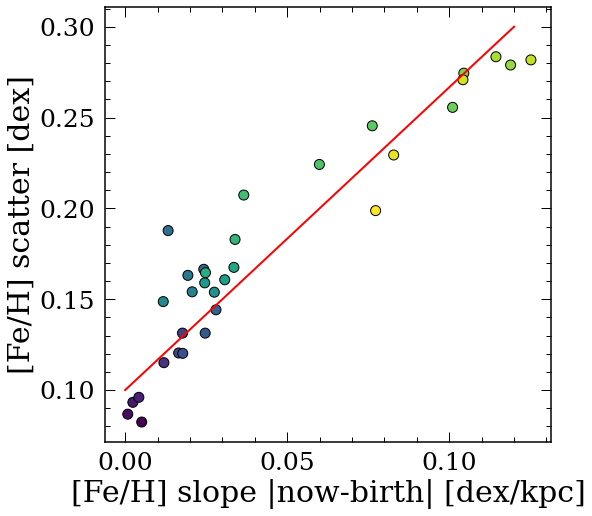

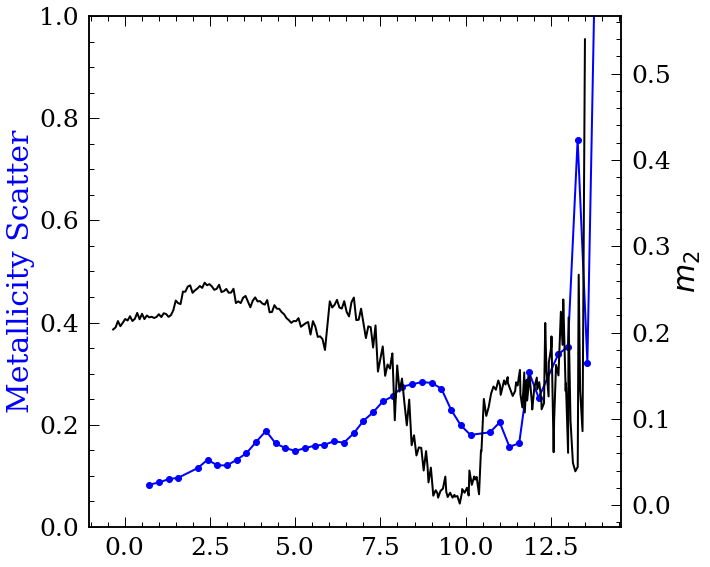

In [735]:

df = pd.read_csv('g2.79e12_fehscatter.csv')
df = pd.merge(df, diskprop, left_on='age', right_on='age', how='inner')
df['disksize_norm'] = df['disksize']/max(df['disksize'])
print(len(df))

plt.figure(figsize=(8,8))
plt.plot(df['age'], df['slopes'], 'r-o')
plt.plot(df['age'], df['slopes_rbir'], 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('Metallicity Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.3, 0.1])

plt.twinx()
plt.plot(df['age'], df['fehscatter'], 'b-o')
m = mergervir>0.1
plt.vlines(mergertimes, ymin=0, ymax=1, color='grey', alpha=0.2, zorder=1)
plt.vlines(mergertimes[m], ymin=0, ymax=1, color='orange', alpha=0.2, zorder=2)
plt.ylim([0,1])
#plt.yscale('log')
plt.ylabel('[Fe/H] Scatter', color='b',zorder=5)



plt.figure(figsize=(8,8))
plt.plot(df['age'], abs(df['slopes_rbir']-df['slopes']), 'r-')
plt.xlabel('Age [Gyr]')
plt.ylabel('Metallicity Slope |now-birth|', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([0, 0.2])

plt.twinx()
plt.plot(df['age'], df['fehscatter'], 'b-')
m = mergervir>0.1
plt.vlines(mergertimes, ymin=0, ymax=1, color='grey', alpha=0.2, zorder=1)
plt.vlines(mergertimes[m], ymin=0, ymax=1, color='orange', alpha=0.2, zorder=2)
plt.ylim([0,0.4])
#plt.yscale('log')
plt.ylabel('[Fe/H] Scatter', color='b',zorder=5)


plt.figure(figsize=(8,8))
m = df['age']<10
plt.scatter(abs(df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m]/(df['disksize_norm'][m]), 
           c=df['age'][m], s=100, edgecolor='k')
plt.xlabel('([Fe/H] slope |now-birth| [dex/kpc])/disksize_norm')
plt.ylabel('[Fe/H] scatter [dex]')
plt.plot([0,0.15], [0,1.5], 'r-')


plt.figure(figsize=(8,8))
m = df['age']<10
plt.scatter(abs(df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m], 
           c=df['age'][m], s=100, edgecolor='k')
plt.xlabel('[Fe/H] slope |now-birth| [dex/kpc]')
plt.ylabel('[Fe/H] scatter [dex]')
plt.plot([0,0.12], [0.1,0.3], 'r-')



plt.figure(figsize=(10,8))
p = fitpoints(df['age'], df['fehscatter'])
plt.plot(df['age'], df['fehscatter'], 'b-o')
plt.ylabel('Metallicity Scatter', color='b',zorder=10)
plt.ylim([0,1])
plt.twinx()
plt.plot(13.8-m2pattern['time'], m2pattern['m2'], 'k-')
plt.ylabel('$m_2$', color='k')
plt.xlabel('Age [Gyr]')
plt.tight_layout()

#plt.figure(figsize=(10,8))
#plt.plot(fehscatter-p(ages), mass_ave, 'ko')

100%|██████████| 49/49 [01:06<00:00,  1.37s/it]


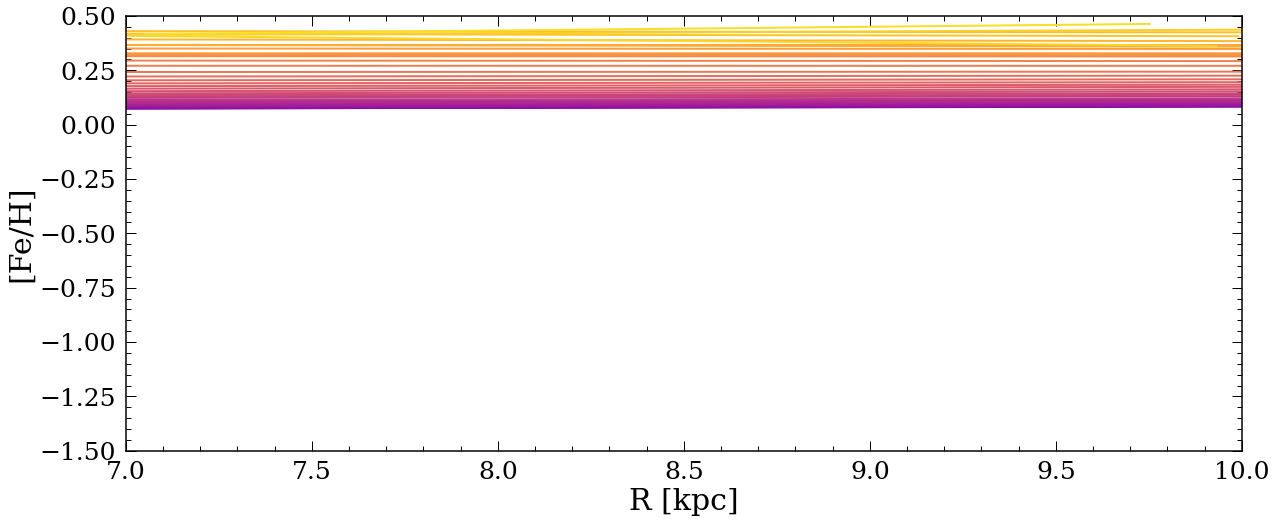

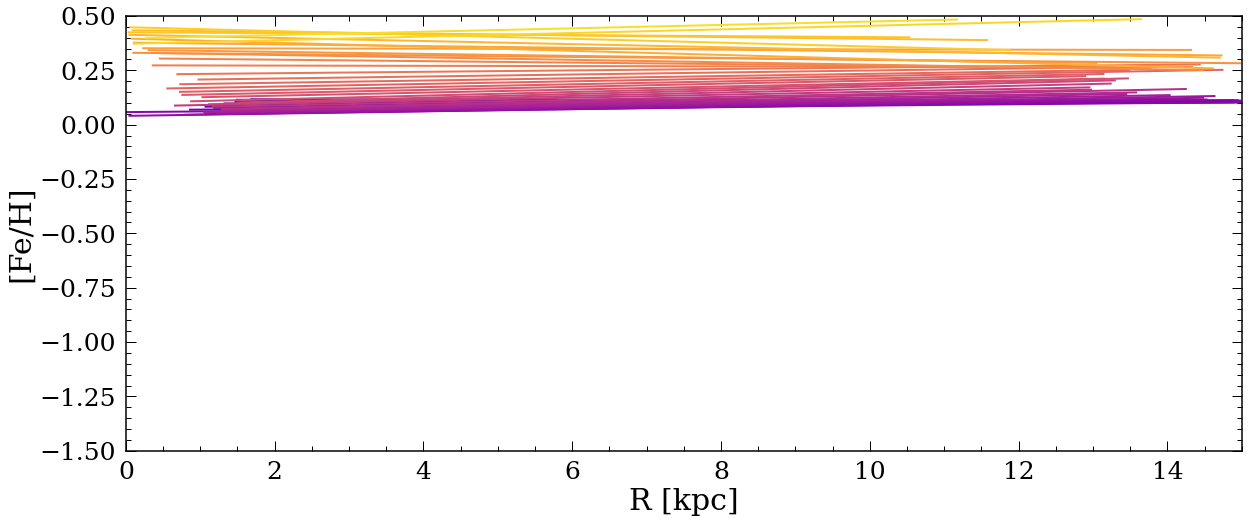

In [738]:
import warnings
warnings.filterwarnings('ignore')


m = (data['R']>7)&(data['R']<10)
ages, slopes, fehscatter = monoage_line(data['ofe'].values[m], 
                                        data['R'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,14,50),
                                        xlims=[7,10],plotlegend=False)

ages, slopes_rbir, fehscatter_rbir = monoage_line(data['ofe'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,14,50),
                                        xlims=[0,15],plotlegend=False)




Text(0, 0.5, '[α/Fe] Scatter')

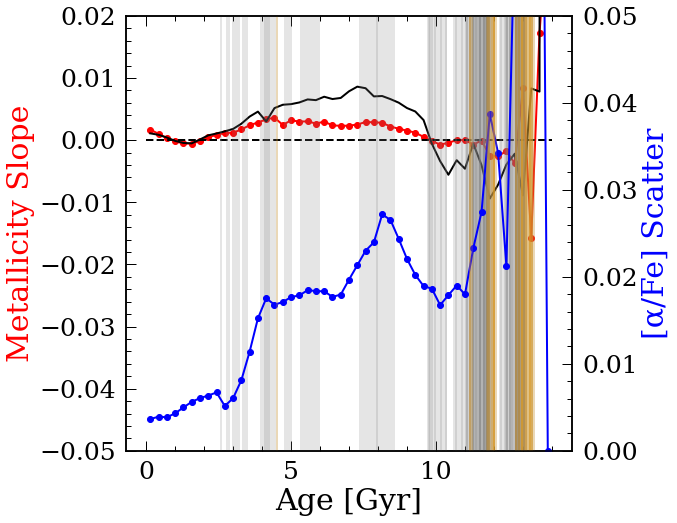

In [739]:

df =  pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir'])

plt.figure(figsize=(8,8))
plt.plot(df['age'], df['slopes'], 'r-o')
plt.plot(df['age'], df['slopes_rbir'], 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('[α/Fe] Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.05, 0.02])

plt.twinx()
plt.plot(df['age'], df['fehscatter'], 'b-o')
m = mergervir>0.1
plt.vlines(mergertimes, ymin=0, ymax=1, color='grey', alpha=0.2, zorder=1)
plt.vlines(mergertimes[m], ymin=0, ymax=1, color='orange', alpha=0.2, zorder=2)
plt.ylim([0,0.05])
#plt.yscale('log')
plt.ylabel('[α/Fe] Scatter', color='b',zorder=5)




100%|██████████| 49/49 [00:53<00:00,  1.10s/it]


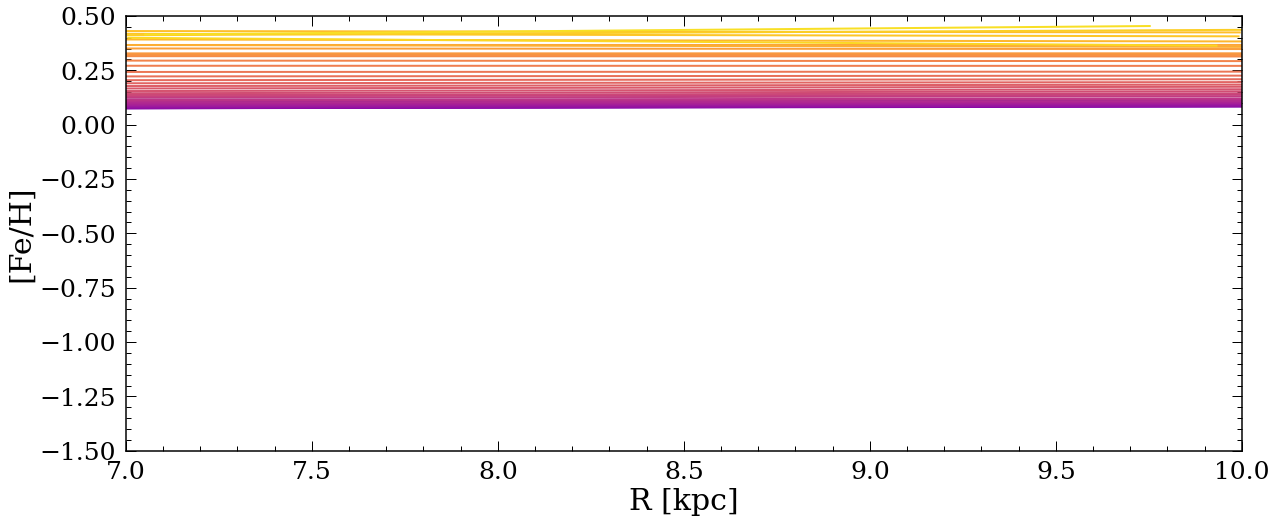

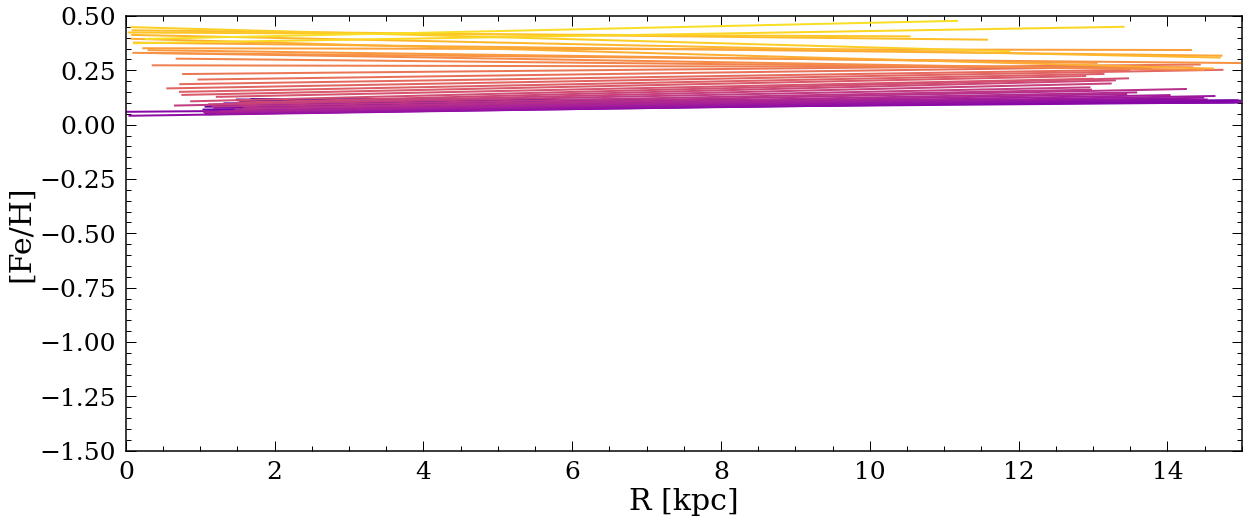

In [740]:
import warnings
warnings.filterwarnings('ignore')


m = (data['R']>7)&(data['R']<10)
m = m&(abs(data['z'])>0.2)
ages, slopes, fehscatter = monoage_line(data['ofe'].values[m], 
                                        data['R'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,14,50),
                                        xlims=[7,10],plotlegend=False)

ages, slopes_rbir, fehscatter_rbir = monoage_line(data['ofe'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,14,50),
                                        xlims=[0,15],plotlegend=False)





Text(0, 0.5, '[α/Fe] Scatter')

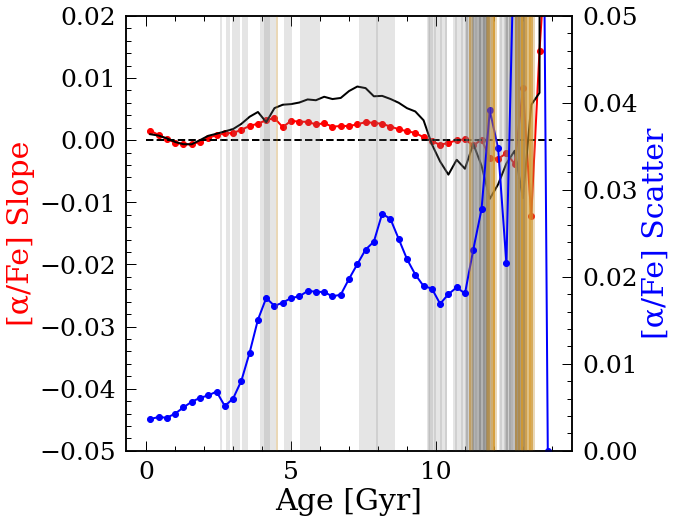

In [742]:

df =  pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir'])

plt.figure(figsize=(8,8))
plt.plot(df['age'], df['slopes'], 'r-o')
plt.plot(df['age'], df['slopes_rbir'], 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('[α/Fe] Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.05, 0.02])

plt.twinx()
plt.plot(df['age'], df['fehscatter'], 'b-o')
m = mergervir>0.1
plt.vlines(mergertimes, ymin=0, ymax=1, color='grey', alpha=0.2, zorder=1)
plt.vlines(mergertimes[m], ymin=0, ymax=1, color='orange', alpha=0.2, zorder=2)
plt.ylim([0,0.05])
#plt.yscale('log')
plt.ylabel('[α/Fe] Scatter', color='b',zorder=5)





## + err

In [743]:
import warnings
warnings.filterwarnings('ignore')

data['age_new'] = [np.random.normal(i, 0.5) for i in data['age']]
data['rbir_new'] = [np.random.normal(i, 1.12+1) for i in data['R_bir']]
data['R_new'] = [np.random.normal(i, 0.31) for i in data['R']]


100%|██████████| 14/14 [00:21<00:00,  1.55s/it]


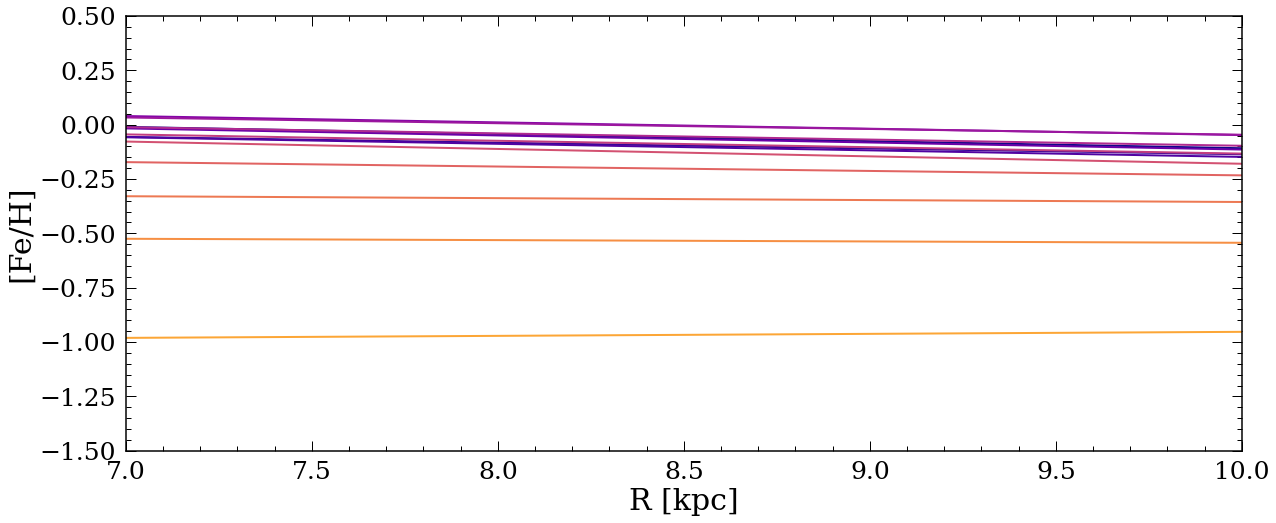

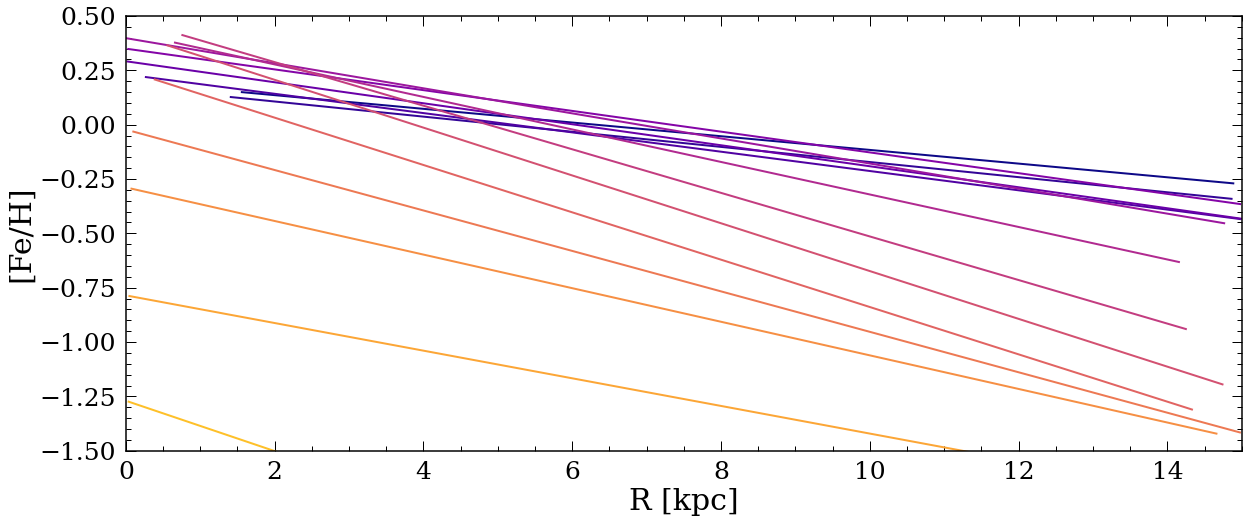

In [753]:
m = (data['R']>7)&(data['R']<10)
ages, slopes, fehscatter = monoage_line(data['feh'].values[m], 
                                        data['R_new'].values[m], 
                                        data['age_new'].values[m],
                                        agebin=np.linspace(0,14,15),
                                        xlims=[7,10],plotlegend=False)

ages, slopes_rbir, fehscatter_rbir = monoage_line(data['feh'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age_new'].values[m],
                                        agebin=np.linspace(0,14,15),
                                        xlims=[0,15],plotlegend=False)



In [754]:
pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir']).to_csv('g2.79e12_fehscatter_simdata.csv', 
                                                index=False)




In [755]:
ismslope = pd.read_pickle('../NIHAORbirth/ISM_slope_g279e12.pkl')
m2pattern = pd.read_pickle('ISM_slope_g279e12.pkl')
merger = pd.read_pickle('./g2.79e12_merger_Lucy.dat')

mergertimes = 13.8-merger['time']
mergervir = merger['vir_ratio']

agebin=np.linspace(0,14,50)
mass_ave = np.zeros(len(agebin)-1)

agebin=np.linspace(0,14,50)
for i in range(len(agebin)-1):
    m = (mergertimes>agebin[i])&(mergertimes<agebin[i+1])
    #mass_ave[i] = sum(mergervir[m])
    if sum(m) == 0:
        mass_ave[i] = 0
    else:
        mass_ave[i] = sum(mergervir[m])/sum(m)

10


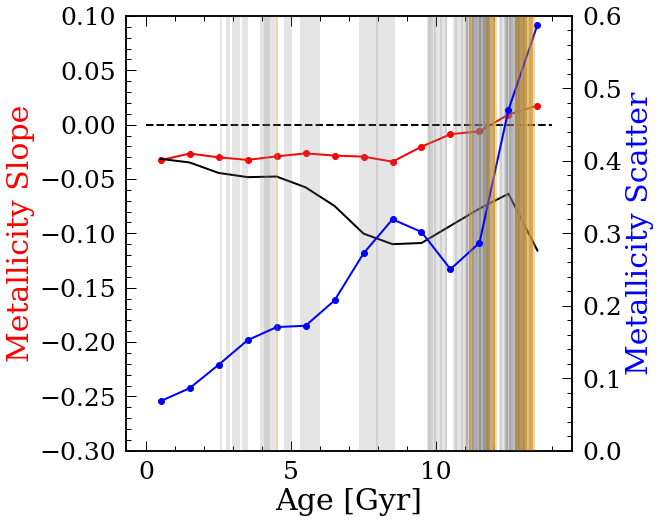

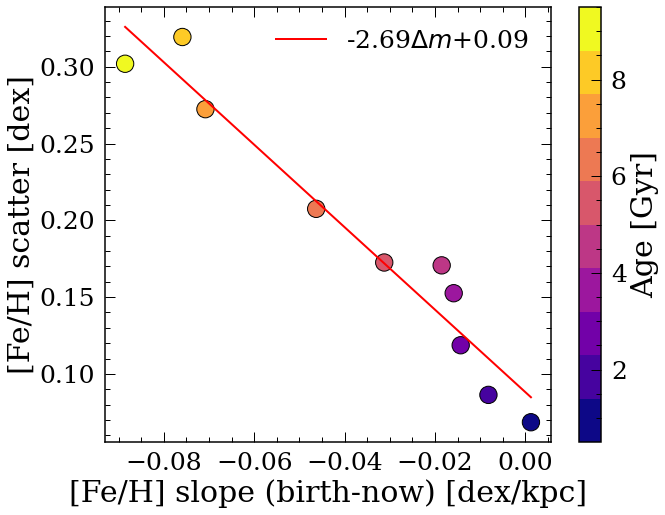

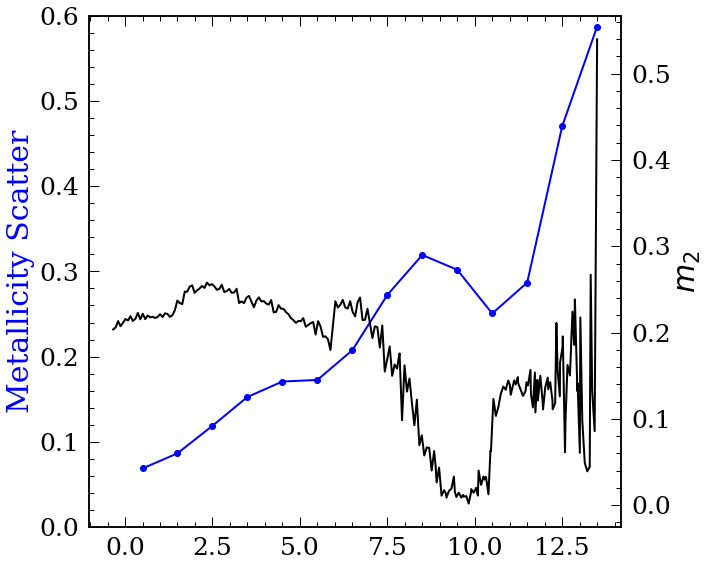

In [756]:
plt.figure(figsize=(8,8))
plt.plot(ages, slopes, 'r-o')
plt.plot(ages, slopes_rbir, 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('Metallicity Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.3, 0.1])

plt.twinx()
plt.plot(ages, fehscatter, 'b-o')
m = mergervir>0.1
plt.vlines(mergertimes, ymin=0, ymax=1, color='grey', alpha=0.2, zorder=1)
plt.vlines(mergertimes[m], ymin=0, ymax=1, color='orange', alpha=0.2, zorder=2)
plt.ylim([0,0.6])
plt.ylabel('Metallicity Scatter', color='b',zorder=5)

df = pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir'])

"""plt.figure(figsize=(10,8))
m = df['age']<10
plt.scatter(abs(df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m]/(df['disksize_norm'][m]), 
           c=df['age'][m], s=100, edgecolor='k', cmap=plt.get_cmap('plasma', sum(m)))
plt.xlabel('([Fe/H] slope |now-birth| [dex/kpc])/disksize_norm')
plt.ylabel('[Fe/H] scatter [dex]')
plt.plot([0,0.15], [0,1.5], 'r-')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')"""


plt.figure(figsize=(10,8))
m = df['age']<10
print(sum(m))
plt.scatter((df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m], 
           c=df['age'][m], s=300, edgecolor='k', 
            cmap=plt.get_cmap('plasma', sum(m)))
p = fitpoints((df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m])
plt.xlabel('[Fe/H] slope (birth-now) [dex/kpc]')
plt.ylabel('[Fe/H] scatter [dex]')
plt.plot((df['slopes_rbir']-df['slopes'])[m], 
         p((df['slopes_rbir']-df['slopes'])[m]), 'r-', 
         label="%.2f$Δm$+%.2f"%(p[1],p[0]))
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.legend()
#plt.xlim([-0.01,0.12])
#plt.ylim([0.06,0.3])


plt.figure(figsize=(10,8))
p = fitpoints(ages, fehscatter)
plt.plot(ages, fehscatter, 'b-o')
plt.ylabel('Metallicity Scatter', color='b',zorder=10)
plt.ylim([0,0.6])
plt.twinx()
plt.plot(13.8-m2pattern['time'], m2pattern['m2'], 'k-')
plt.ylabel('$m_2$', color='k')
plt.xlabel('Age [Gyr]')
plt.tight_layout()

#plt.figure(figsize=(10,8))
#plt.plot(fehscatter-p(ages), mass_ave, 'ko')

100%|██████████| 14/14 [00:22<00:00,  1.58s/it]


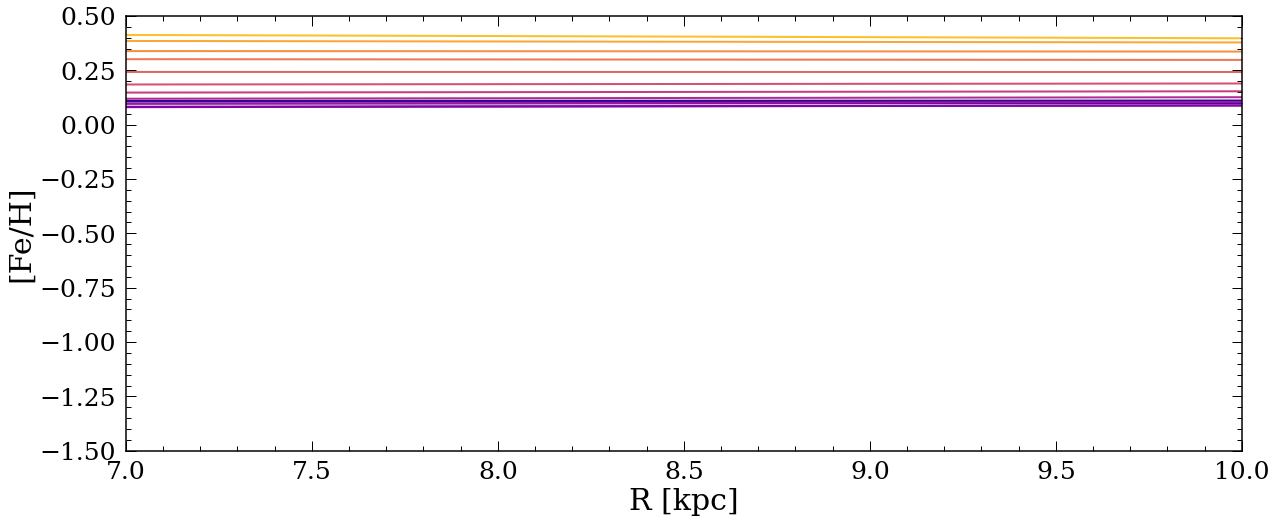

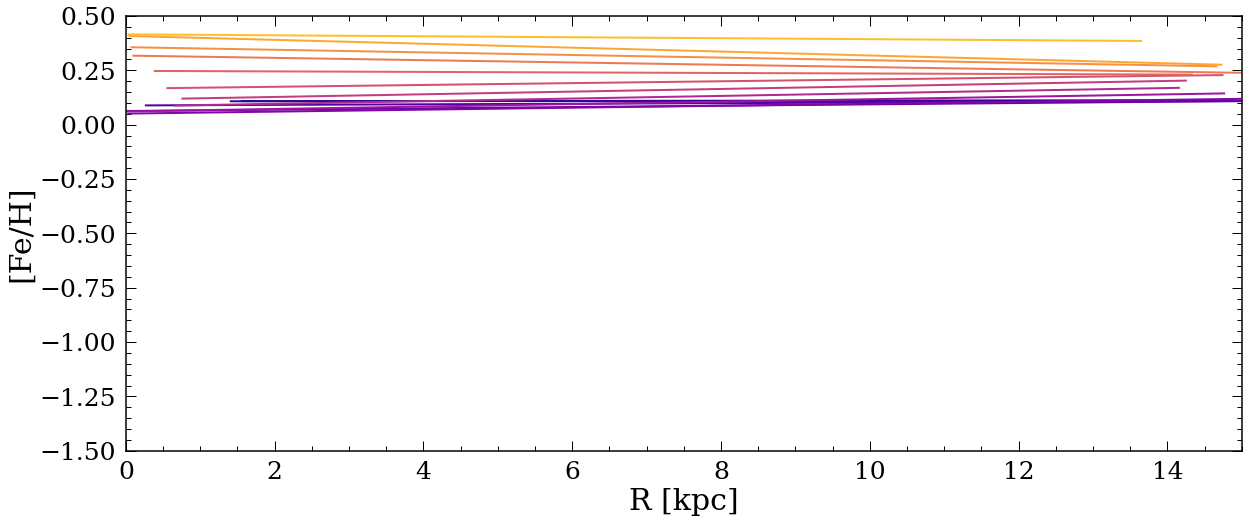

In [757]:
m = (data['R']>7)&(data['R']<10)
ages, slopes, fehscatter = monoage_line(data['ofe'].values[m], 
                                        data['R_new'].values[m], 
                                        data['age_new'].values[m],
                                        agebin=np.linspace(0,14,15),
                                        xlims=[7,10],plotlegend=False)

ages, slopes_rbir, fehscatter_rbir = monoage_line(data['ofe'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age_new'].values[m],
                                        agebin=np.linspace(0,14,15),
                                        xlims=[0,15],plotlegend=False)

10


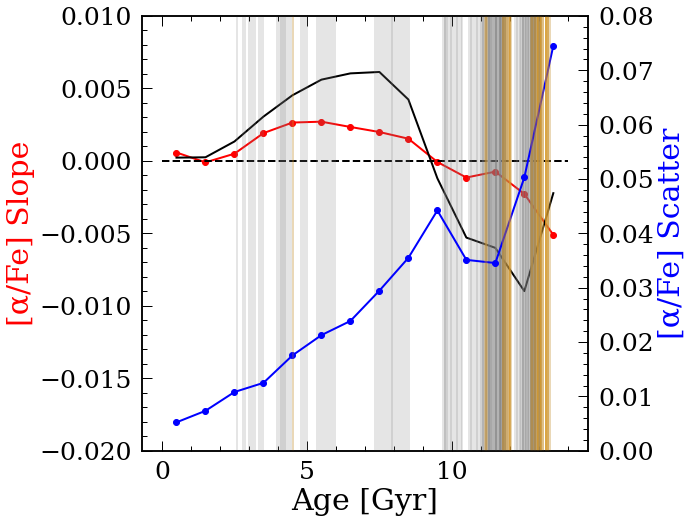

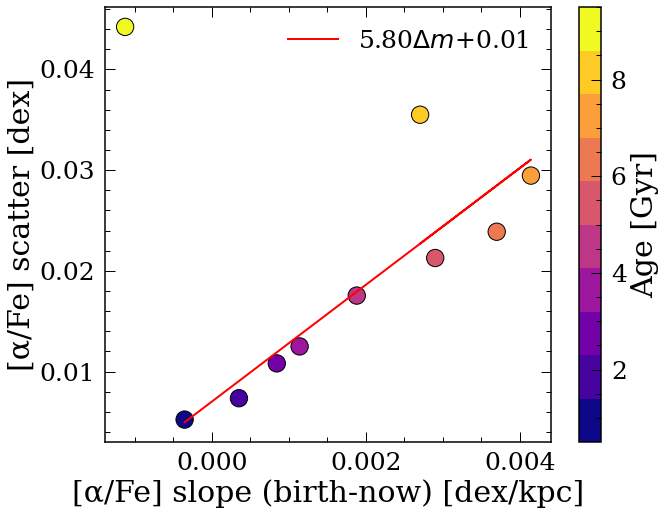

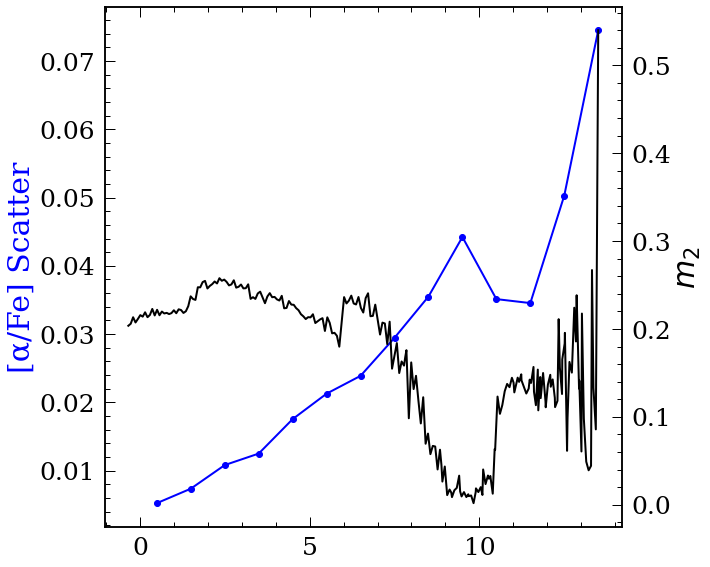

In [758]:
plt.figure(figsize=(8,8))
plt.plot(ages, slopes, 'r-o')
plt.plot(ages, slopes_rbir, 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('[α/Fe] Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.02, 0.01])

plt.twinx()
plt.plot(ages, fehscatter, 'b-o')
m = mergervir>0.1
plt.vlines(mergertimes, ymin=0, ymax=1, color='grey', alpha=0.2, zorder=1)
plt.vlines(mergertimes[m], ymin=0, ymax=1, color='orange', alpha=0.2, zorder=2)
plt.ylim([0,0.08])
plt.ylabel('[α/Fe] Scatter', color='b',zorder=5)


"""plt.figure(figsize=(10,8))
m = df['age']<10
plt.scatter(abs(df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m]/(df['disksize_norm'][m]), 
           c=df['age'][m], s=100, edgecolor='k', cmap=plt.get_cmap('plasma', sum(m)))
plt.xlabel('([Fe/H] slope |now-birth| [dex/kpc])/disksize_norm')
plt.ylabel('[Fe/H] scatter [dex]')
plt.plot([0,0.15], [0,1.5], 'r-')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
"""

df = pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir'])

plt.figure(figsize=(10,8))
m = df['age']<10

print(sum(m))
plt.scatter((df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m], 
           c=df['age'][m], s=300, edgecolor='k', 
            cmap=plt.get_cmap('plasma', sum(m)))

m = m&((df['slopes_rbir']-df['slopes'])<0.005)
m = m&(df['fehscatter']<0.04)

p = fitpoints((df['slopes_rbir']-df['slopes'])[m], df['fehscatter'][m])

plt.xlabel('[α/Fe] slope (birth-now) [dex/kpc]')
plt.ylabel('[α/Fe] scatter [dex]')
plt.plot((df['slopes_rbir']-df['slopes'])[m], 
         p((df['slopes_rbir']-df['slopes'])[m]), 'r-', 
         label="%.2f$Δm$+%.2f"%(p[1],p[0]))
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.legend()

plt.figure(figsize=(10,8))
p = fitpoints(ages, fehscatter)
plt.plot(ages, fehscatter, 'b-o')
plt.ylabel('[α/Fe] Scatter', color='b',zorder=10)
#plt.ylim([0,0.6])
plt.twinx()
plt.plot(13.8-m2pattern['time'], m2pattern['m2'], 'k-')
plt.ylabel('$m_2$', color='k')
plt.xlabel('Age [Gyr]')
plt.tight_layout()

#plt.figure(figsize=(10,8))
#plt.plot(fehscatter-p(ages), mass_ave, 'ko')

In [759]:
df = pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir'])
pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir']).to_csv('g2.79e12_ofescatter_simdata.csv', 
                                                index=False)




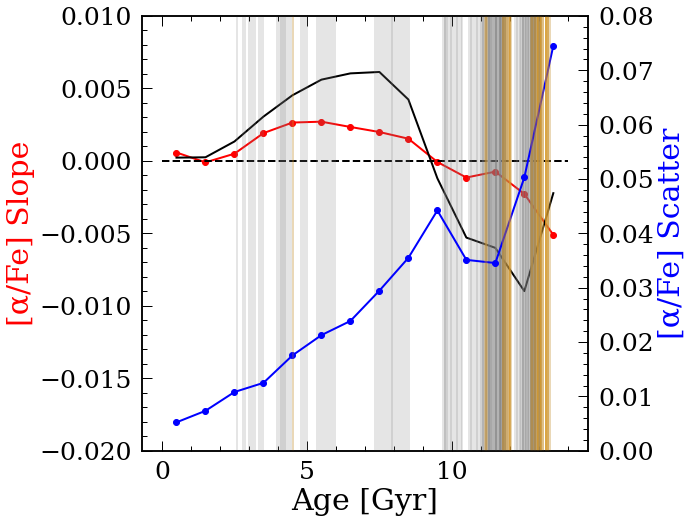

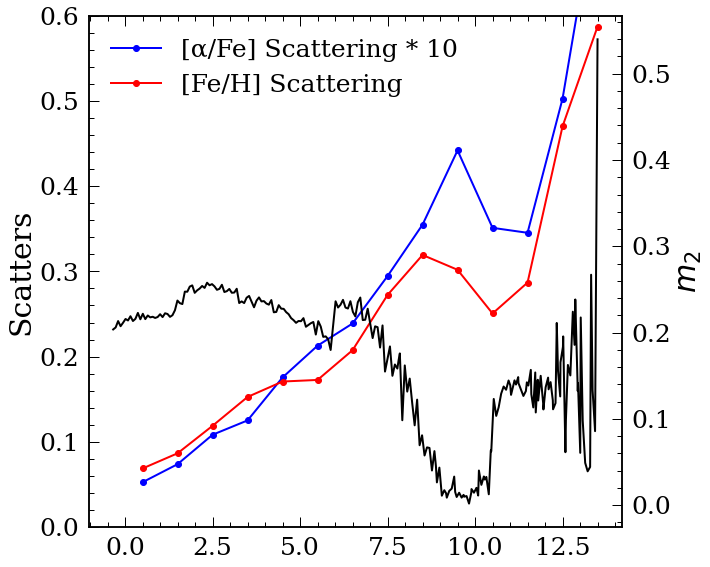

In [760]:
plt.figure(figsize=(8,8))
plt.plot(ages, slopes, 'r-o')
plt.plot(ages, slopes_rbir, 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('[α/Fe] Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.02, 0.01])

plt.twinx()
plt.plot(ages, fehscatter, 'b-o')
m = mergervir>0.1
plt.vlines(mergertimes, ymin=0, ymax=1, color='grey', alpha=0.2, zorder=1)
plt.vlines(mergertimes[m], ymin=0, ymax=1, color='orange', alpha=0.2, zorder=2)
plt.ylim([0,0.08])
plt.ylabel('[α/Fe] Scatter', color='b',zorder=5)

df = pd.read_csv('g2.79e12_fehscatter_simdata.csv')
df_ofe = pd.read_csv('g2.79e12_ofescatter_simdata.csv')

plt.figure(figsize=(10,8))
#p = fitpoints(ages, fehscatter)
plt.plot(df_ofe['age'], df_ofe['fehscatter']*10, 'b-o', label='[α/Fe] Scattering * 10')
plt.plot(df['age'], df['fehscatter'], 'r-o', label='[Fe/H] Scattering')
plt.ylabel('Scatters',zorder=10)
plt.ylim([0,0.6])
plt.legend(loc=2)
plt.twinx()
plt.plot(13.8-m2pattern['time'], m2pattern['m2'], 'k-')
plt.ylabel('$m_2$', color='k')
plt.xlabel('Age [Gyr]')
plt.tight_layout()

#plt.figure(figsize=(10,8))
#plt.plot(fehscatter-p(ages), mass_ave, 'ko')

# Scatter with R

In [763]:
m = (abs(data['z'])<1)
#data['age_new'] = [np.random.normal(i, 1) for i in data['age']]
#data['feh_new'] = [np.random.normal(i, 0.05) for i in data['feh']]
ages, rs, scatters = getscatt(data['feh'].values[m], 
                                        data['R'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,14,10),
                                        xlims=[0,15],rbin=10)




(0.0, 0.5)

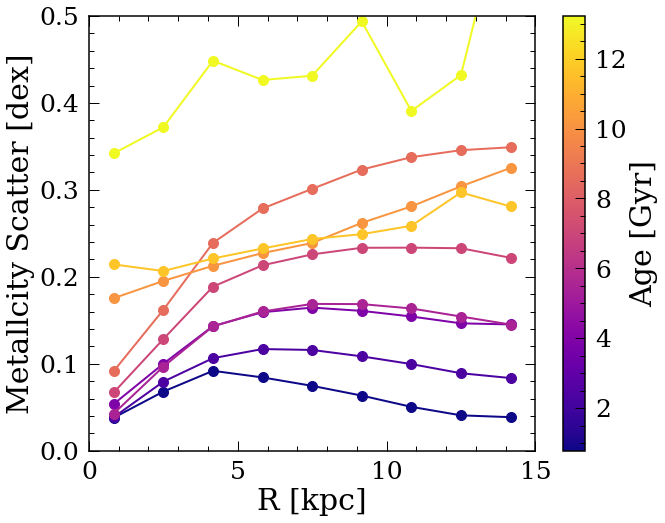

In [764]:
colors = getcolor(ages)
plt.figure(figsize=(10,8))
for i in range(len(ages)):
    plt.plot(rs, scatters[i,:], '-o', color=colors[i], markersize=10)
plt.scatter(-10,-10,c=0, vmin=min(ages), vmax=max(ages),cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.xlabel('R [kpc]')
plt.ylabel('Metallcity Scatter [dex]')
plt.xlim([0,15])
plt.ylim([0,0.5])

In [766]:
m = (abs(data['z'])<1)
data['age_new'] = [np.random.normal(i, 1) for i in data['age']]
data['feh_new'] = [np.random.normal(i, 0.05) for i in data['feh']]
ages, rs, scatters = getscatt(data['feh_new'].values[m], 
                                        data['R'].values[m], 
                                        data['age_new'].values[m],
                                        agebin=np.linspace(0,14,10),
                                        xlims=[0,15],rbin=10)



(0.0, 0.5)

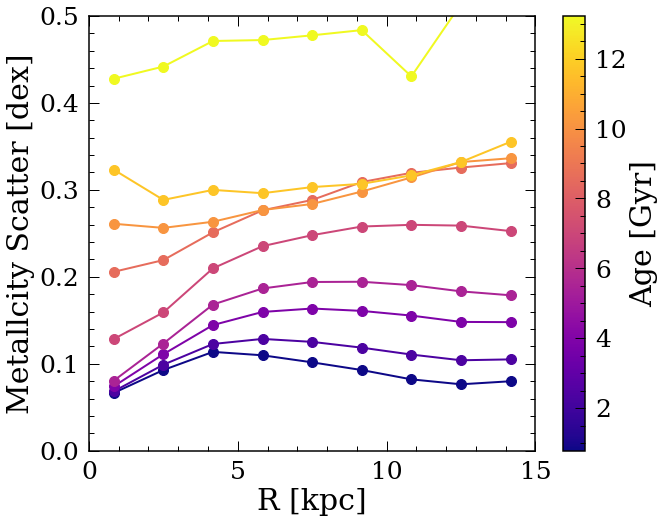

In [767]:
colors = getcolor(ages)
plt.figure(figsize=(10,8))
for i in range(len(ages)):
    plt.plot(rs, scatters[i,:], '-o', color=colors[i], markersize=10)
plt.scatter(-10,-10,c=0, vmin=min(ages), vmax=max(ages),cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.xlabel('R [kpc]')
plt.ylabel('Metallcity Scatter [dex]')
plt.xlim([0,15])
plt.ylim([0,0.5])

In [768]:
m = (abs(data['z'])<1)
#data['age_new'] = [np.random.normal(i, 1) for i in data['age']]
#data['feh_new'] = [np.random.normal(i, 0.05) for i in data['feh']]
ages, rs, scatters = getscatt(data['feh'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,14,10),
                                        xlims=[0,15],rbin=10)





(0.0, 0.5)

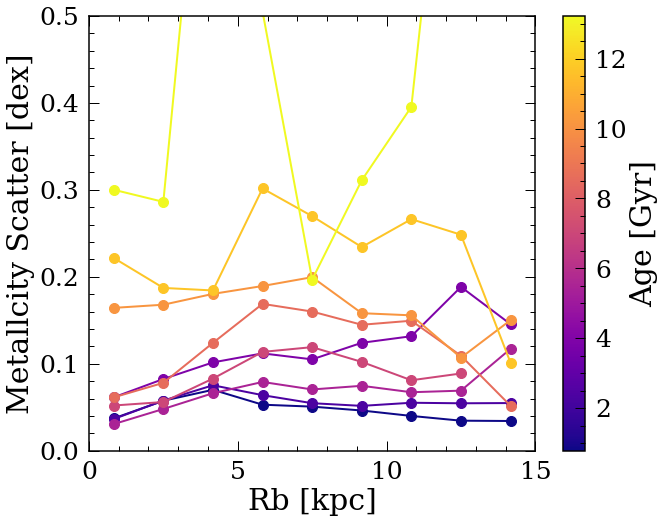

In [769]:
colors = getcolor(ages)
plt.figure(figsize=(10,8))
for i in range(len(ages)):
    plt.plot(rs, scatters[i,:], '-o', color=colors[i], markersize=10)
plt.scatter(-10,-10,c=0, vmin=min(ages), vmax=max(ages),cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.xlabel('Rb [kpc]')
plt.ylabel('Metallcity Scatter [dex]')
plt.xlim([0,15])
plt.ylim([0,0.5])


In [328]:
"""plt.figure(figsize=(10,8))
plt.imshow(scatters[:,::-1].T-0.05, cmap='plasma', 
           extent=(ages[0], ages[-1], rs[0], rs[-1]), vmin=0, vmax=0.3)
plt.xlabel('Age [Gyr]')
plt.ylabel('R [kpc]')
cb = plt.colorbar()
cb.set_label('Metellicity Scatter')
"""

"plt.figure(figsize=(10,8))\nplt.imshow(scatters[:,::-1].T-0.05, cmap='plasma', \n           extent=(ages[0], ages[-1], rs[0], rs[-1]), vmin=0, vmax=0.3)\nplt.xlabel('Age [Gyr]')\nplt.ylabel('R [kpc]')\ncb = plt.colorbar()\ncb.set_label('Metellicity Scatter')\n"

In [326]:
ages, rs, scatters = getscatt(data['feh_new'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age_new'].values[m],
                                        agebin=np.linspace(0,14,10),
                                        xlims=[0,15],rbin=10)



(0.0, 0.5)

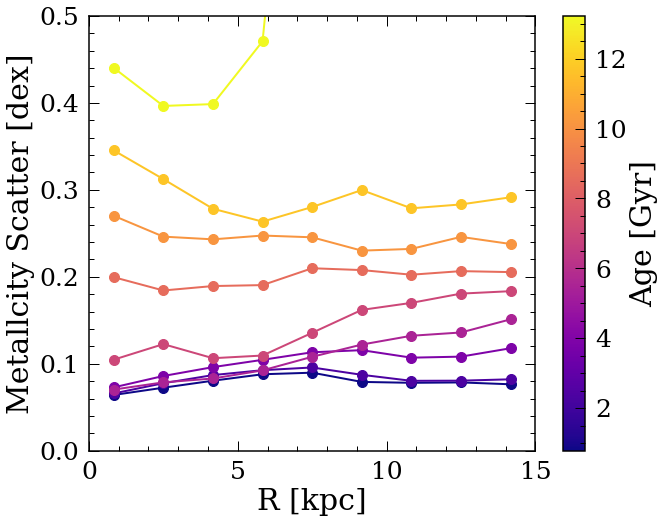

In [329]:
colors = getcolor(ages)
plt.figure(figsize=(10,8))
for i in range(len(ages)):
    plt.plot(rs, scatters[i,:], '-o', color=colors[i], markersize=10)
plt.scatter(-10,-10,c=0, vmin=min(ages), vmax=max(ages),cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.xlabel('R [kpc]')
plt.ylabel('Metallcity Scatter [dex]')
plt.xlim([0,15])
plt.ylim([0,0.5])


# compare to mirgration

In [773]:
def getmigration(r, rbir, age, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5]):
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    r, rbir, age = r[m], rbir[m], age[m]
    
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, rbir_sing = r[m], rbir[m]

        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                scatters[i,j] = np.nan
            else:
                r_sing_2, rbir_sing_2 = r_sing[m], rbir_sing[m]
                scatters[i,j] = np.std(rbir_sing_2-r_sing_2)

                
    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters




In [774]:
m = (abs(data['z'])<0.5)
ages, rs, sigmaR = getmigration(data['R'].values[m],
                                data['R_bir'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,14,10),
                                        xlims=[0,15],rbin=10)




(0.0, 4.0)

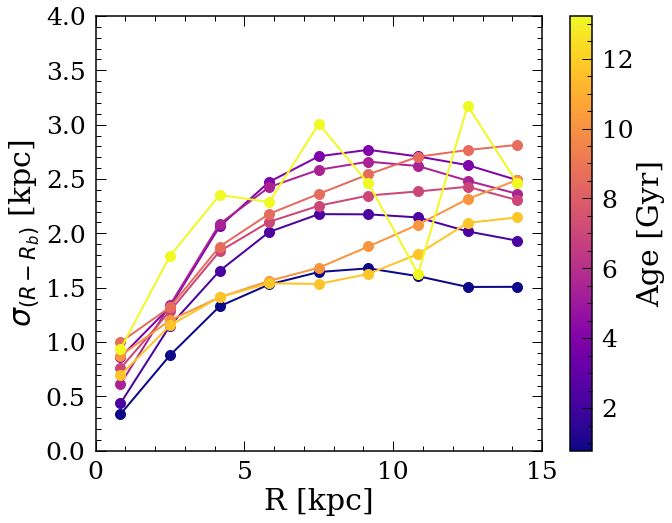

In [776]:
colors = getcolor(ages)
plt.figure(figsize=(10,8))
for i in range(len(ages)):
    plt.plot(rs, sigmaR[i,:], '-o', color=colors[i], markersize=10)
plt.scatter(-10,-10,c=0, vmin=min(ages), vmax=max(ages),cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.xlabel('R [kpc]')
plt.ylabel('$σ_{(R-R_b)}$ [kpc]')
plt.xlim([0,15])
plt.ylim([0,4])




### +err

In [777]:
m = (abs(data['z'])<0.5)
ages, rs, sigmaR = getscatt(data['rbir_new'].values[m], 
                                        data['R_new'].values[m], 
                                        data['age_new'].values[m],
                                        agebin=np.linspace(0,14,10),
                                        xlims=[0,15],rbin=10)





(0.0, 4.0)

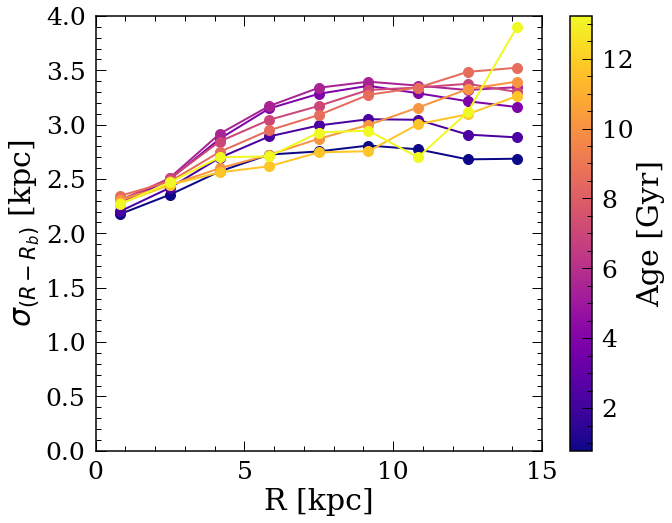

In [779]:
colors = getcolor(ages)
plt.figure(figsize=(10,8))
for i in range(len(ages)):
    plt.plot(rs, sigmaR[i,:], '-o', color=colors[i], markersize=10)
plt.scatter(-10,-10,c=0, vmin=min(ages), vmax=max(ages),cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.xlabel('R [kpc]')
plt.ylabel('$σ_{(R-R_b)}$ [kpc]')
plt.xlim([0,15])
plt.ylim([0,4])





### random stuff

In [780]:
sim_scat = []
sim_migr = []
sim_ages = []
sim_rs = []
for i in range(np.shape(scatters)[0]):
    for j in range(np.shape(scatters)[1]):
        sim_scat.append(scatters[i,j])
        sim_migr.append(sigmaR[i,j])
        sim_ages.append(ages[i])
        sim_rs.append(rs[j])

(0.0, 0.5)

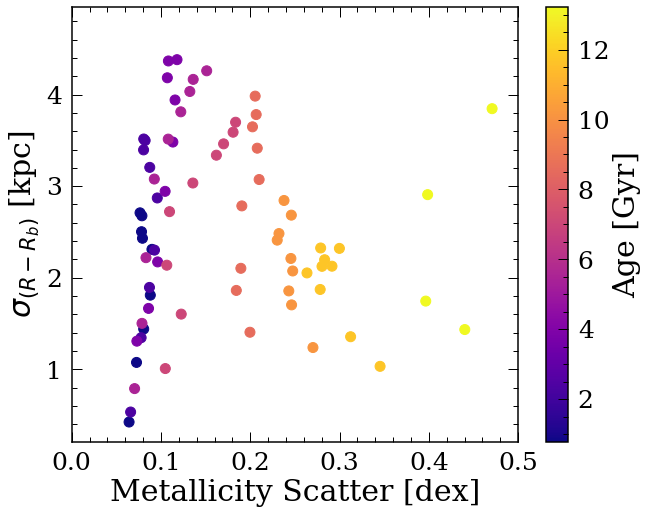

In [334]:
"""plt.figure(figsize=(10,8))
mage = (np.array(sim_ages)>0)
plt.scatter(np.array(sim_scat)[mage], np.array(sim_migr)[mage], 
            c=np.array(sim_ages)[mage], 
            s=100, cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.xlabel('Metallicity Scatter [dex]')
plt.ylabel('$σ_{(R-R_b)}$ [kpc]')"""


plt.figure(figsize=(10,8))
mage = (np.array(sim_ages)>0)
plt.scatter(np.array(sim_scat)[mage], np.array(sim_migr)[mage], 
            c=np.array(sim_ages)[mage], 
            s=100, cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.xlabel('Metallicity Scatter [dex]')
plt.ylabel('$σ_{(R-R_b)}$ [kpc]')
plt.xlim([0,0.5])

(0.0, 0.5)

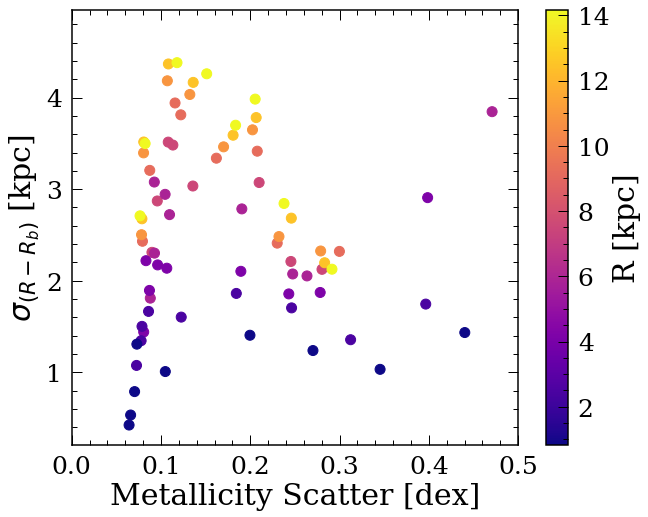

In [335]:
"""plt.figure(figsize=(10,8))
plt.scatter(sim_scat, sim_migr, c=sim_rs, s=100, cmap='plasma')
cb = plt.colorbar()
cb.set_label('R [kpc]')
plt.xlabel('Metallicity Scatter [dex]')
plt.ylabel('$σ_{(R-R_b)}$ [kpc]')
"""

plt.figure(figsize=(10,8))
plt.scatter(sim_scat, sim_migr, c=sim_rs, s=100, cmap='plasma')
cb = plt.colorbar()
cb.set_label('R [kpc]')
plt.xlabel('Metallicity Scatter [dex]')
plt.ylabel('$σ_{(R-R_b)}$ [kpc]')
plt.xlim([0,0.5])

In [336]:
"""def getcolor(vrange, cmap=plt.cm.get_cmap('plasma')):
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    #print([cmap(norm(i)) for i in vrange])
    return [cmap(norm(i)) for i in vrange]

m2 = (np.array(sim_ages)<10)
sim_scat_age, sim_migr_age, sim_rs_age = np.array(sim_scat)[m2], np.array(sim_migr)[m2], np.array(sim_rs)[m2]
sim_ages_age = np.array(sim_ages)[m2]

colors = getcolor(rs)
for i in range(len(rs)):
    m = (sim_rs_age==rs[i])
    scattersing, migrsing = np.array(sim_scat_age)[m], np.array(sim_migr_age)[m]
    scattersing, migrsing = zip(*sorted(zip(scattersing, migrsing)))
    plt.plot(scattersing, migrsing, c=colors[i])
    
m = (sim_ages_age==sim_ages[550])
scattersing, migrsing = np.array(sim_scat_age)[m], np.array(sim_migr_age)[m]
scattersing, migrsing = zip(*sorted(zip(scattersing, migrsing)))
plt.plot(scattersing, migrsing, 'r-', linewidth=10)

m = (sim_ages_age==sim_ages[300])
scattersing, migrsing = np.array(sim_scat_age)[m], np.array(sim_migr_age)[m]
scattersing, migrsing = zip(*sorted(zip(scattersing, migrsing)))
plt.plot(scattersing, migrsing, 'r-', linewidth=10)

    
cb.set_label('R [kpc]')
plt.xlabel('Metallicity Scatter [dex]')
plt.ylabel('$σ_{(R-R_b)}$ [kpc]')
plt.xlim([0,0.5])"""

"def getcolor(vrange, cmap=plt.cm.get_cmap('plasma')):\n    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))\n    #print([cmap(norm(i)) for i in vrange])\n    return [cmap(norm(i)) for i in vrange]\n\nm2 = (np.array(sim_ages)<10)\nsim_scat_age, sim_migr_age, sim_rs_age = np.array(sim_scat)[m2], np.array(sim_migr)[m2], np.array(sim_rs)[m2]\nsim_ages_age = np.array(sim_ages)[m2]\n\ncolors = getcolor(rs)\nfor i in range(len(rs)):\n    m = (sim_rs_age==rs[i])\n    scattersing, migrsing = np.array(sim_scat_age)[m], np.array(sim_migr_age)[m]\n    scattersing, migrsing = zip(*sorted(zip(scattersing, migrsing)))\n    plt.plot(scattersing, migrsing, c=colors[i])\n    \nm = (sim_ages_age==sim_ages[550])\nscattersing, migrsing = np.array(sim_scat_age)[m], np.array(sim_migr_age)[m]\nscattersing, migrsing = zip(*sorted(zip(scattersing, migrsing)))\nplt.plot(scattersing, migrsing, 'r-', linewidth=10)\n\nm = (sim_ages_age==sim_ages[300])\nscattersing, migrsing = np.array(sim_sca

In [546]:
"""m = (sim_rs_age==rs[20])
scattersing, migrsing = np.array(sim_scat_age)[m], np.array(sim_migr_age)[m]
scattersing, migrsing = zip(*sorted(zip(scattersing, migrsing)))
plt.plot(scattersing, migrsing, 'k-', linewidth=10)

m = (sim_ages_age==sim_ages[550])
scattersing, migrsing = np.array(sim_scat_age)[m], np.array(sim_migr_age)[m]
scattersing, migrsing = zip(*sorted(zip(scattersing, migrsing)))
plt.plot(scattersing, migrsing, 'r-', linewidth=10)

m = (sim_ages_age==sim_ages[300])
scattersing, migrsing = np.array(sim_scat_age)[m], np.array(sim_migr_age)[m]
scattersing, migrsing = zip(*sorted(zip(scattersing, migrsing)))
plt.plot(scattersing, migrsing, 'r-', linewidth=10)"""

"m = (sim_rs_age==rs[20])\nscattersing, migrsing = np.array(sim_scat_age)[m], np.array(sim_migr_age)[m]\nscattersing, migrsing = zip(*sorted(zip(scattersing, migrsing)))\nplt.plot(scattersing, migrsing, 'k-', linewidth=10)\n\nm = (sim_ages_age==sim_ages[550])\nscattersing, migrsing = np.array(sim_scat_age)[m], np.array(sim_migr_age)[m]\nscattersing, migrsing = zip(*sorted(zip(scattersing, migrsing)))\nplt.plot(scattersing, migrsing, 'r-', linewidth=10)\n\nm = (sim_ages_age==sim_ages[300])\nscattersing, migrsing = np.array(sim_scat_age)[m], np.array(sim_migr_age)[m]\nscattersing, migrsing = zip(*sorted(zip(scattersing, migrsing)))\nplt.plot(scattersing, migrsing, 'r-', linewidth=10)"

In [781]:
data['vr'] = (data['x'] * data['vx'] + data['y'] * data['vy'])/data['R']
data['vphi'] = -(data['x'] * data['vy'] - data['y'] * data['vx'])/data['R']


In [789]:
m = (abs(data['z'])<1)&(abs(data['R']-8.2)<2)

In [791]:
ages, rs, avrs_z = avr(data['age'].values[m], data['R_bir'].values[m], data['vz'].values[m], 
                     rbin=np.linspace(2,15,5), agebin=np.linspace(0,14,30))

ages, rs, avrs_phi = avr(data['age'].values[m], data['R_bir'].values[m], data['vphi'].values[m], 
                     rbin=np.linspace(2,15,5), agebin=np.linspace(0,14,30))

ages, rs, avrs_r = avr(data['age'].values[m], data['R_bir'].values[m], data['vr'].values[m], 
                     rbin=np.linspace(2,15,5), agebin=np.linspace(0,14,30))

100%|██████████| 4/4 [01:05<00:00, 16.39s/it]


In [792]:
print(ages, rs, avrs_z, avrs_phi, avrs_r)


[ 0.24137931  0.72413793  1.20689655  1.68965517  2.17241379  2.65517241
  3.13793103  3.62068966  4.10344828  4.5862069   5.06896552  5.55172414
  6.03448276  6.51724138  7.          7.48275862  7.96551724  8.44827586
  8.93103448  9.4137931   9.89655172 10.37931034 10.86206897 11.34482759
 11.82758621 12.31034483 12.79310345 13.27586207 13.75862069] [ 3.625  6.875 10.125 13.375] [[ 13.81865152  16.9740403   19.74711363  24.38529292  29.79081599
   33.54235862  35.41196574  38.13020741  40.50064113  40.42278171
   43.30995104  45.29749381  46.99537602  47.85493879  49.01107005
   50.49834837  53.19149439  55.43029134  56.74667131  57.8260202
   60.51211822  63.6114675   74.71032163  77.85267534  83.52261704
   86.13579973  88.85989009  67.34705175          nan]
 [ 17.26417384  21.79985092  26.20255379  30.29858825  36.2725542
   42.27673617  44.24590751  48.049808    51.06980324  52.64478541
   53.73810383  55.18539644  55.48243536  55.08386726  58.83599886
   59.86156318  60.76297666

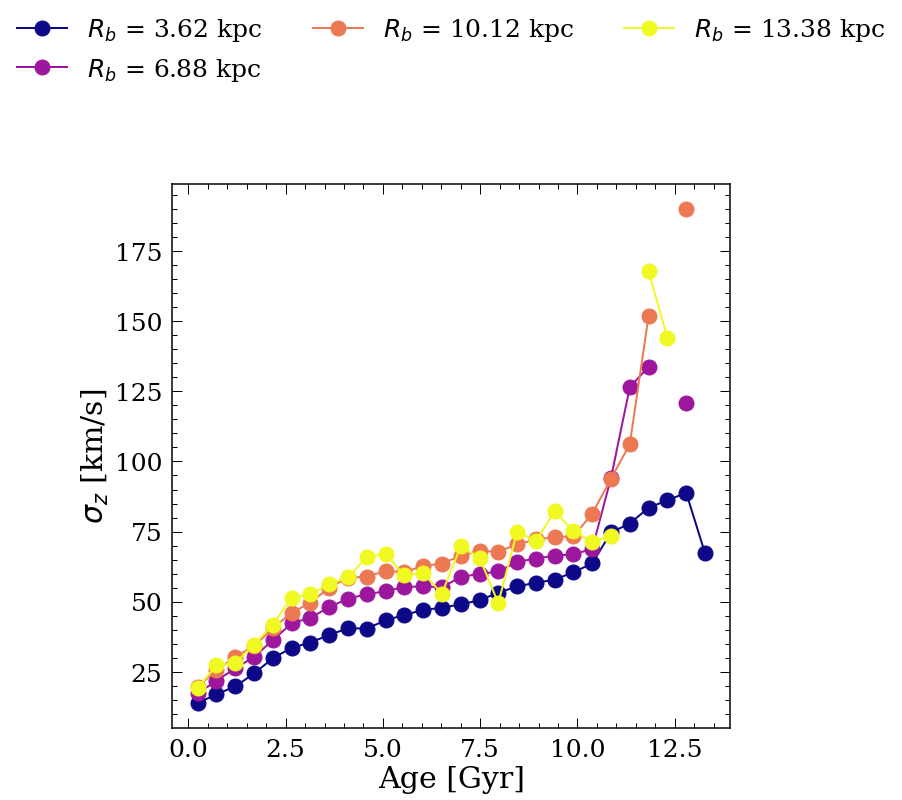

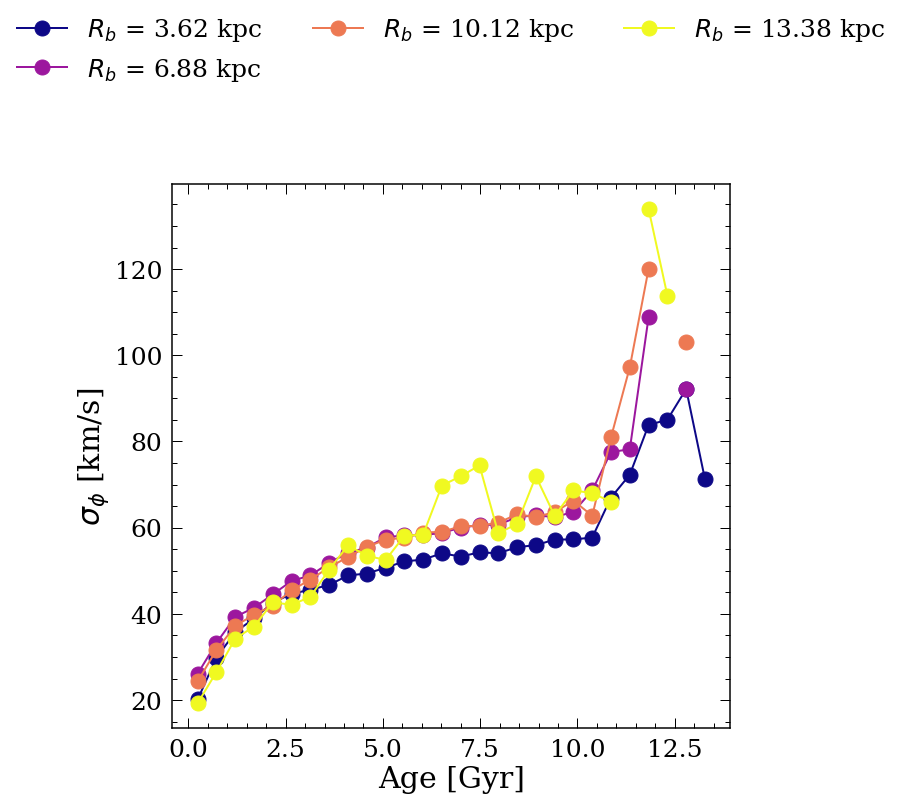

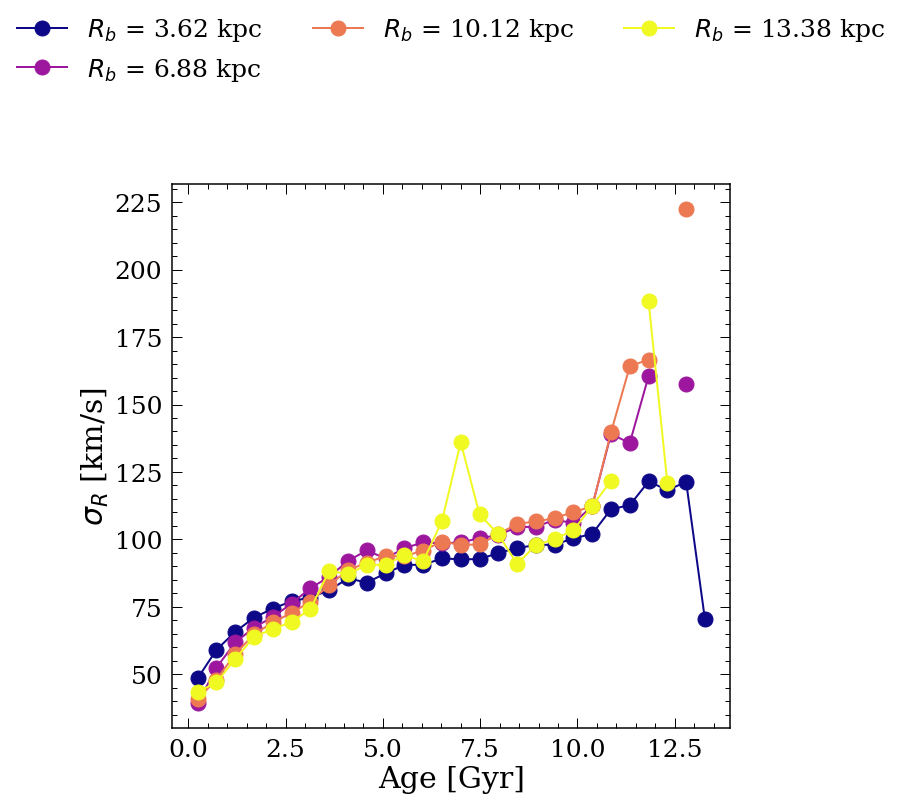

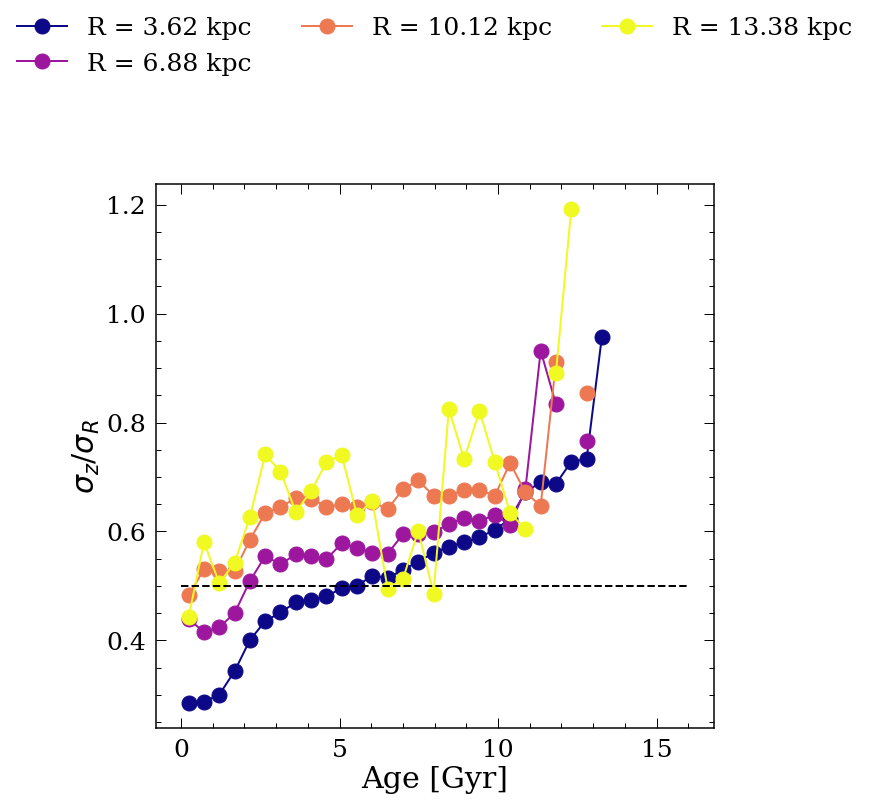

In [793]:
colors = getcolor(rs)

plt.figure()
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:], 'o-', color=colors[i], label='$R_b$ = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_z$ [km/s]')
#plt.ylim([0, 80])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)



plt.figure()
for i in range(len(rs)):
    plt.plot(ages, avrs_phi[i,:], 'o-', color=colors[i], label='$R_b$ = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_ϕ$ [km/s]')
#plt.ylim([10,40])
#plt.ylim([0, 120])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)



plt.figure()
for i in range(len(rs)):
    plt.plot(ages, avrs_r[i,:], 'o-', color=colors[i], label='$R_b$ = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_R$ [km/s]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)


plt.figure()
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:]/avrs_r[i,:], 'o-', color=colors[i], label='R = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_z$/$σ_R$')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)

plt.plot([0,16], [0.5,0.5], 'k--')

In [794]:
ages, rs, avrs_z = avr(data['age'].values, data['R'].values, data['vz'].values, 
                     rbin=np.linspace(2,15,5), agebin=np.linspace(0,14,30))

ages, rs, avrs_phi = avr(data['age'].values, data['R'].values, data['vphi'].values, 
                     rbin=np.linspace(2,15,5), agebin=np.linspace(0,14,30))

ages, rs, avrs_r = avr(data['age'].values, data['R'].values, data['vr'].values, 
                     rbin=np.linspace(2,15,5), agebin=np.linspace(0,14,30))

100%|██████████| 4/4 [05:12<00:00, 78.06s/it] 


In [795]:
print(ages, rs, avrs_z, avrs_phi, avrs_r)

[ 0.24137931  0.72413793  1.20689655  1.68965517  2.17241379  2.65517241
  3.13793103  3.62068966  4.10344828  4.5862069   5.06896552  5.55172414
  6.03448276  6.51724138  7.          7.48275862  7.96551724  8.44827586
  8.93103448  9.4137931   9.89655172 10.37931034 10.86206897 11.34482759
 11.82758621 12.31034483 12.79310345 13.27586207 13.75862069] [ 3.625  6.875 10.125 13.375] [[ 17.43169536  20.29514148  23.91286945  29.36611875  35.56075754
   42.74081065  44.51718196  48.88103187  51.39522337  51.17121934
   54.01533513  56.34587398  58.37317196  61.20592878  63.09621744
   66.5571237   70.4880492   75.33173662  78.45597859  79.20783423
   83.41257576  90.76285482 115.44258389 116.57567898 124.17101277
  128.61185064 132.14880669 133.30521883 140.95803961]
 [ 17.13109194  21.72950978  25.79851617  30.11805993  35.78219254
   42.3072596   43.98972438  48.55900213  53.83341364  52.70510326
   54.21819424  54.82498816  56.42572199  56.38101148  58.69501679
   58.70735693  60.788444

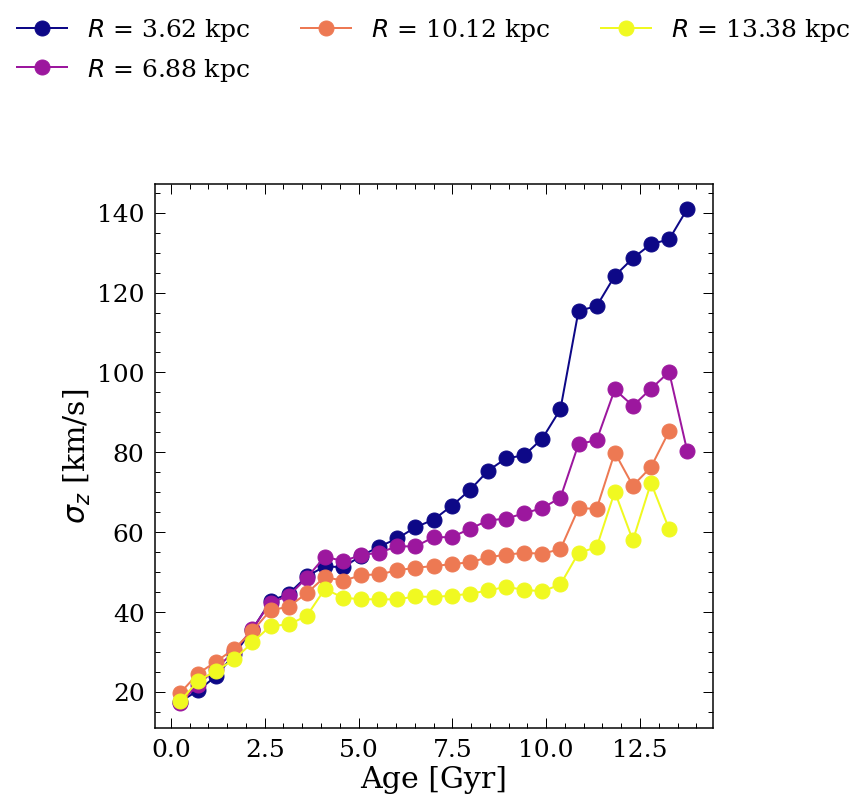

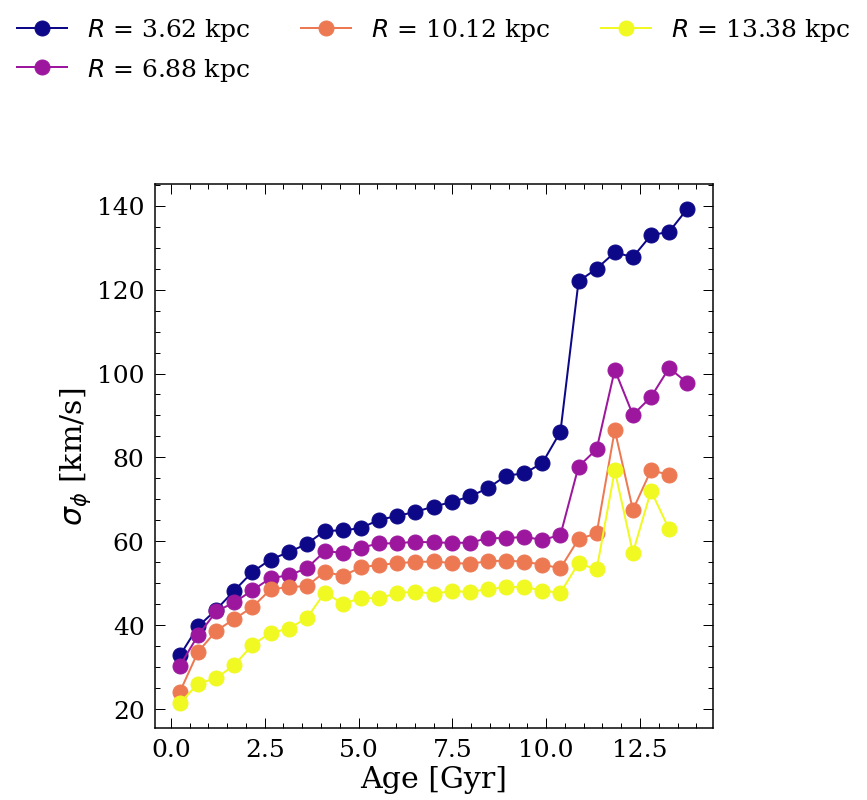

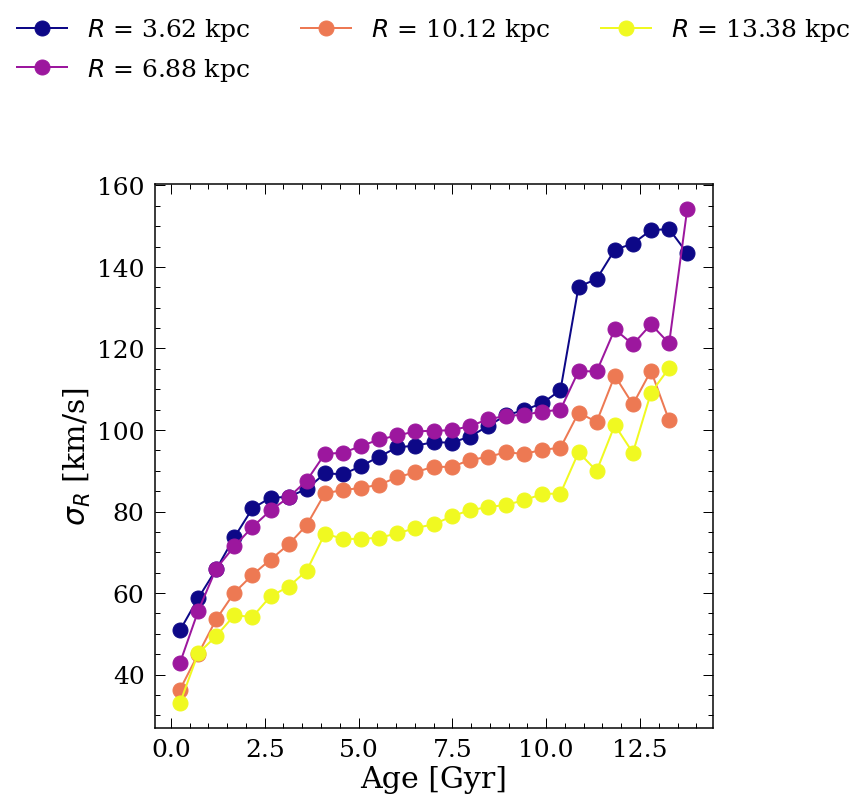

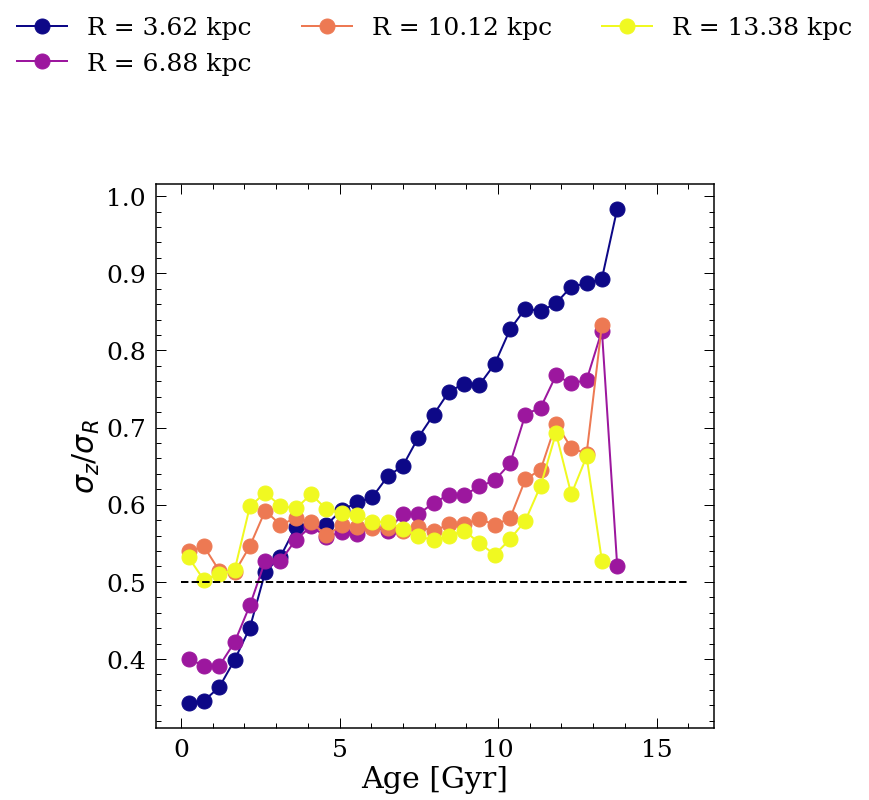

In [796]:
colors = getcolor(rs)

plt.figure()
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:], 'o-', color=colors[i], label='$R$ = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_z$ [km/s]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)



plt.figure()
for i in range(len(rs)):
    plt.plot(ages, avrs_phi[i,:], 'o-', color=colors[i], label='$R$ = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_ϕ$ [km/s]')
#plt.ylim([10,40])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)



plt.figure()
for i in range(len(rs)):
    plt.plot(ages, avrs_r[i,:], 'o-', color=colors[i], label='$R$ = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_R$ [km/s]')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)

plt.figure()
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:]/avrs_r[i,:], 'o-', color=colors[i], label='R = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_z$/$σ_R$')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)

plt.plot([0,16], [0.5,0.5], 'k--')

In [797]:
#sub['Rmean'] = (sub['R_PERI']+sub['R_APO'])/2
agebincalc = np.linspace(0,14,8)
#data['vr'] = (data['x'] * data['vx'] + data['y'] * data['vy'])/data['R']
#data['vphi'] = -(data['x'] * data['vy'] - data['y'] * data['vx'])/data['R']


m = (abs(data['z'])<1)&(abs(data['R']-8.2)<2)

ages, rs, avrs_z = avr(data['R_bir'].values[m], data['age'].values[m], data['vz'].values[m], 
                     rbin=agebincalc, agebin=np.linspace(2,15,10))

ages, rs, avrs_phi = avr(data['R_bir'].values[m], data['age'].values[m], data['vphi'].values[m], 
                     rbin=agebincalc, agebin=np.linspace(2,15,10))

ages, rs, avrs_r = avr(data['R_bir'].values[m], data['age'].values[m], data['vr'].values[m], 
                     rbin=agebincalc, agebin=np.linspace(2,15,10))

100%|██████████| 7/7 [00:21<00:00,  3.10s/it]


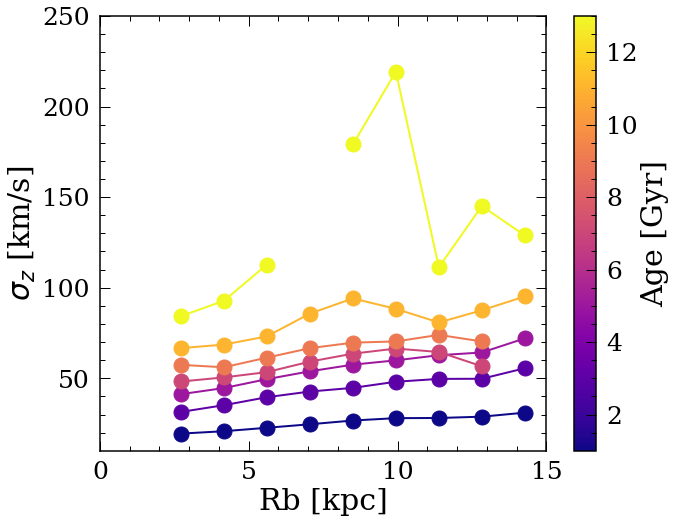

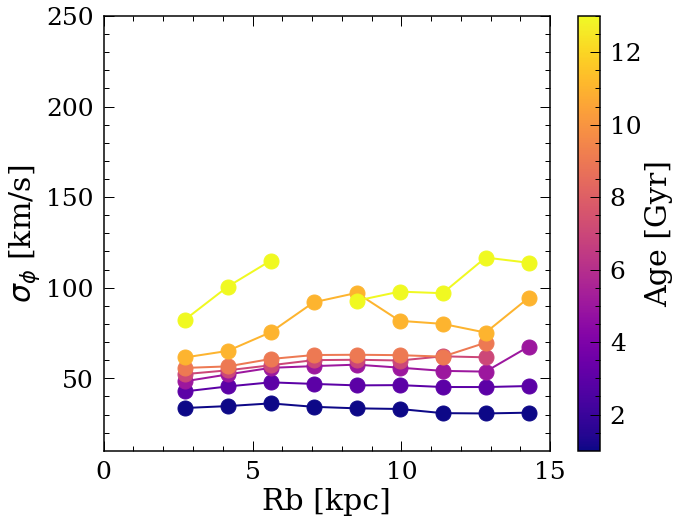

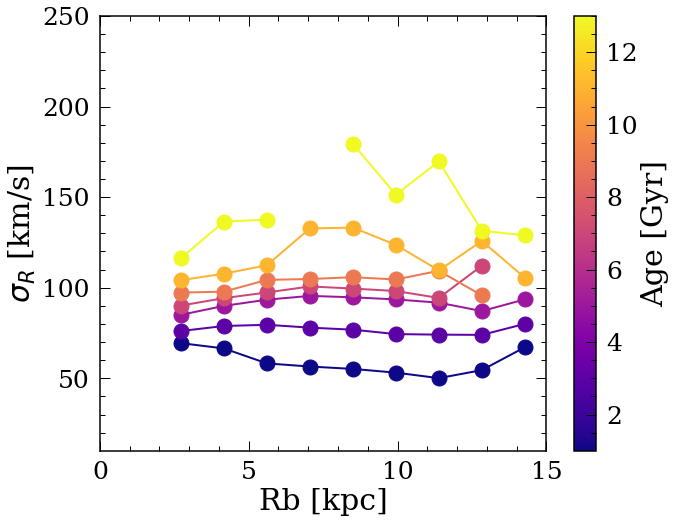

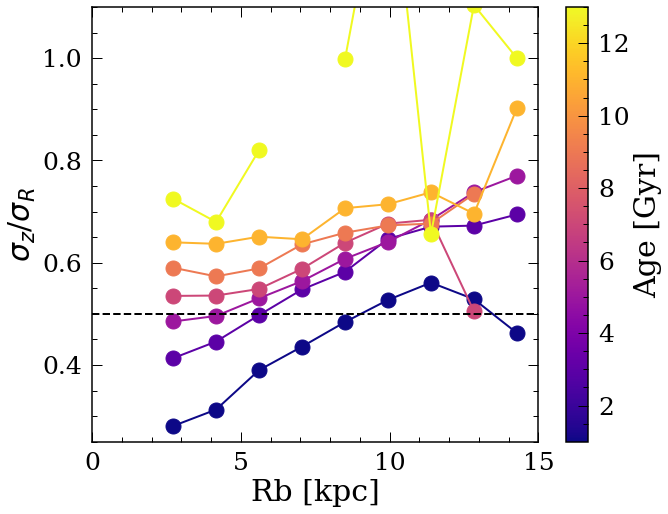

In [799]:

colors = getcolor(rs)

plt.figure(figsize=(10,8))
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],
            markersize=15)
    plt.xlabel('Rb [kpc]')
    plt.ylabel('$σ_z$ [km/s]')
plt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap='plasma')
plt.ylim([10, 250])
plt.xlim([0,15])
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
#plt.legend()



plt.figure(figsize=(10,8))
for i in range(len(rs)):
    plt.plot(ages, avrs_phi[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],
            markersize=15)
    plt.xlabel('Rb [kpc]')
    plt.ylabel('$σ_ϕ$ [km/s]')
plt.ylim([10, 250])
plt.xlim([0,15])
plt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
#plt.legend()



plt.figure(figsize=(10,8))
for i in range(len(rs)):
    plt.plot(ages, avrs_r[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],
            markersize=15)
    plt.xlabel('Rb [kpc]')
    plt.ylabel('$σ_R$ [km/s]')
plt.ylim([10, 250])
plt.xlim([0,15])
plt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
#plt.legend()



plt.figure(figsize=(10,8))
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:]/avrs_r[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],
            markersize=15)
    plt.xlabel('Rb [kpc]')
    plt.ylabel('$σ_z$/$σ_R$')
plt.ylim([0.25, 1.1])
plt.xlim([0,15])
plt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
#plt.legend()

plt.plot([0,16], [0.5,0.5], 'k--')







### check amr and [$\alpha$/Fe]-[Fe/H]

In [404]:
data['age_new'] = [np.random.normal(i, 0.5) for i in data['age']]
data['feh_new'] = [np.random.normal(i, 0.067) for i in data['feh']]
data['R_bir_new'] = [np.random.normal(i, 1.12) for i in data['R_bir']]
data['ofe_new'] = [np.random.normal(i, 0.026) for i in data['ofe']]


Text(0, 0.5, '[Fe/H]')

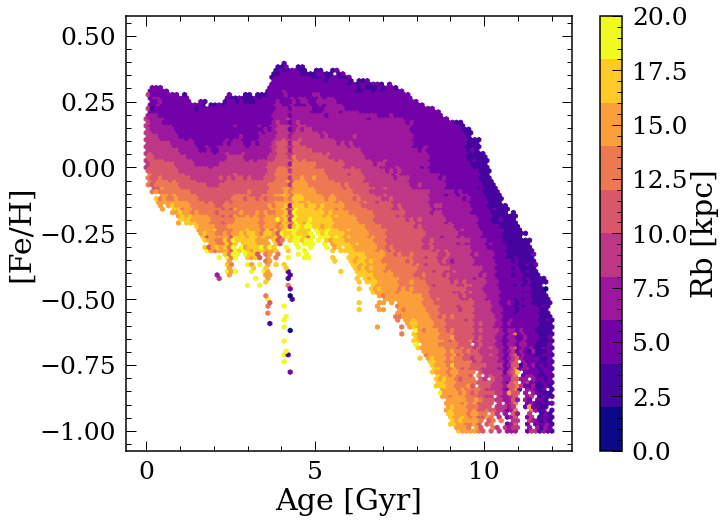

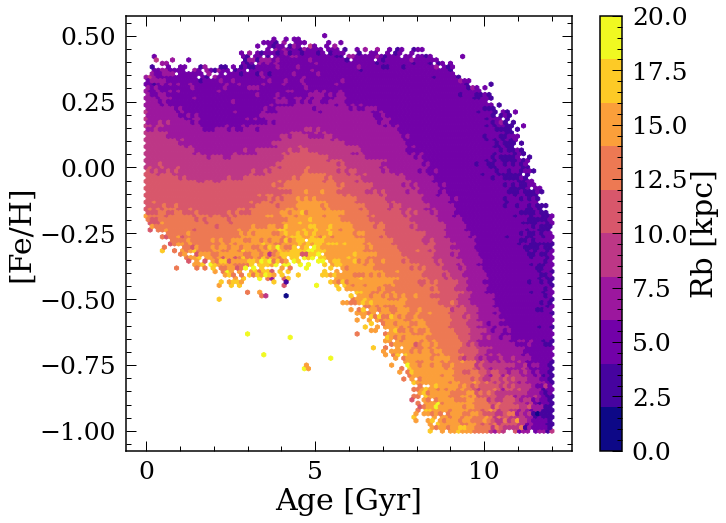

In [405]:
m = (data['R']>8)&(data['R']<10)
plt.figure(figsize=(10,8))
plt.hexbin(data['age'][m], data['feh'][m], C=data['R_bir'][m], 
           extent=(0,12,-1,0.5), cmap=plt.get_cmap('plasma',10),
          mincnt=1,vmin=0,vmax=20)

cb = plt.colorbar()
cb.set_label('Rb [kpc]')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]')




plt.figure(figsize=(10,8))
plt.hexbin(data['age_new'][m], data['feh_new'][m], C=data['R_bir_new'][m], 
           extent=(0,12,-1,0.5), cmap=plt.get_cmap('plasma',10),
          mincnt=1,vmin=0,vmax=20)

cb = plt.colorbar()
cb.set_label('Rb [kpc]')
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]')





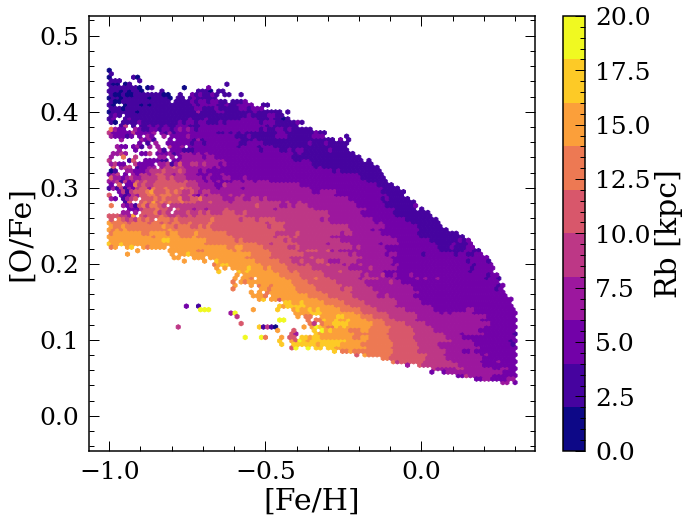

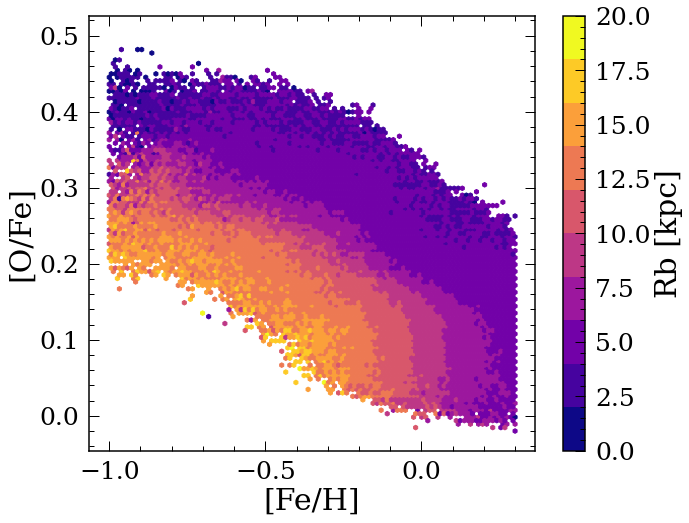

In [407]:
m = (data['R']>8)&(data['R']<10)

plt.figure(figsize=(10,8))
plt.hexbin(data['feh'][m], data['ofe'][m], C=data['R_bir'][m], 
           extent=(-1,0.3,-0.02, 0.5), cmap=plt.get_cmap('plasma',10),
          mincnt=1,vmin=0,vmax=20)

plt.xlabel('[Fe/H]')
plt.ylabel('[O/Fe]')
cb = plt.colorbar()
cb.set_label('Rb [kpc]')





plt.figure(figsize=(10,8))
plt.hexbin(data['feh_new'][m], data['ofe_new'][m], C=data['R_bir_new'][m], 
           extent=(-1,0.3,-0.02, 0.5), cmap=plt.get_cmap('plasma',10),
          mincnt=1,vmin=0,vmax=20)

plt.xlabel('[Fe/H]')
plt.ylabel('[O/Fe]')
cb = plt.colorbar()
cb.set_label('Rb [kpc]')




# try to reproduce the old slope

In [571]:
import Astraea
def monoage_line_var(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[],plotlegend=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    for i in trange(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] = Astraea.getRvar(feh_sing[m2])
        
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter
    


In [572]:
m = (data['R']>7)&(data['R']<10)
ages, slopes, fehscatter = monoage_line_var(data['feh'].values[m], 
                                        data['R'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,14,50),
                                        xlims=[7,10],plotlegend=False)

ages, slopes_rbir, fehscatter_rbir = monoage_line_var(data['feh'].values[m], 
                                        data['R_bir'].values[m], 
                                        data['age'].values[m],
                                        agebin=np.linspace(0,14,50),
                                        xlims=[7,10],plotlegend=False)

100%|██████████| 49/49 [00:50<00:00,  1.03s/it]


In [573]:
m2pattern = pd.read_pickle('ISM_slope_g279e12.pkl')
merger = pd.read_pickle('./g2.79e12_merger_Lucy.dat')

In [582]:
m2pattern.columns

Index(['time', 'slope', 'residual', 'gp_no', 'extend', 'M_gas_hlr2',
       'masses_hlr2', 'M_star_hlr2', 'half_mass_l2', 'pcc',
       ...
       '16.280898876404493_res', '16.48314606741573_res',
       '16.685393258426963_res', '16.8876404494382_res',
       '17.08988764044944_res', '17.29213483146067_res',
       '17.49438202247191_res', '17.696629213483146_res',
       '17.89887640449438_res', 'm2'],
      dtype='object', length=106)

In [583]:
mergertimes = 13.8-merger['time']
mergervir = merger['vir_ratio']

disktime = np.array(13.8-m2pattern['time'])
disksize = np.array(m2pattern['extend'])

agebin=np.linspace(0,14,50)
mass_ave = np.zeros(len(agebin)-1)
disksize_ave = np.zeros(len(agebin)-1)


agebin=np.linspace(0,14,50)
for i in range(len(agebin)-1):
    m = (mergertimes>agebin[i])&(mergertimes<agebin[i+1])
    m2 = (disktime>agebin[i])&(disktime<agebin[i+1])
    #mass_ave[i] = sum(mergervir[m])
    if sum(m) == 0:
        mass_ave[i] = 0
    else:
        mass_ave[i] = sum(mergervir[m])/sum(m)
        
        
    if sum(m2) == 0:
        disksize_ave[i] = np.nan
    else:
        disksize_ave[i] = np.mean(disksize[m2])
        
        
df = pd.DataFrame(np.array((ages, slopes, fehscatter, slopes_rbir, fehscatter_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir'])

diskprop = pd.DataFrame(np.array(((agebin[1:]+agebin[:-1])/2, disksize_ave)).T,
                       columns=['age', 'disksize'])

df = pd.merge(df, diskprop, left_on='age', right_on='age', how='inner')
df['disksize_norm'] = df['disksize']/max(df['disksize'])

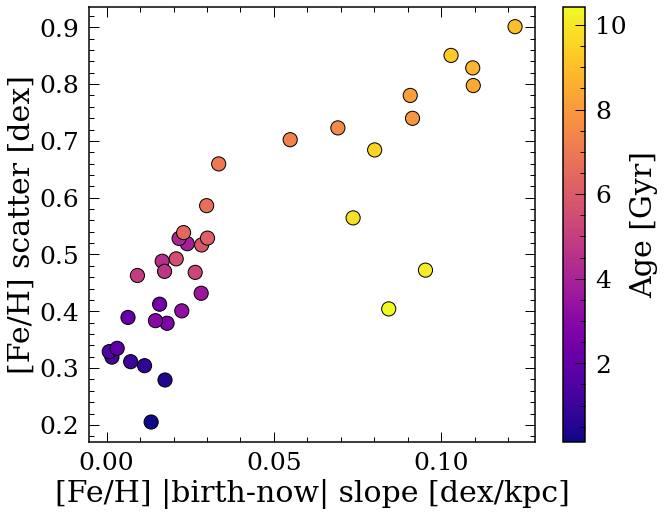

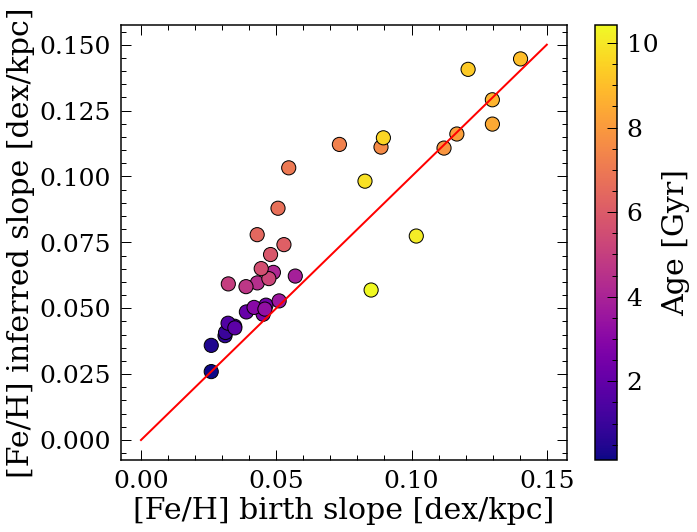

In [618]:



plt.figure(figsize=(10,8))
m = df['age']<10.5

df['slopeinfer'] = df['fehscatter']/(df['disksize_norm'])

slopenorm = df.loc[df['age']==min(df['age'])]['slopes_rbir'][0]/df.loc[df['age']==min(df['age'])]['slopeinfer'][0]
df['slopeinfer'] = df['slopeinfer']*slopenorm
    
plt.scatter(abs(df['slopes_rbir']-df['slopes'])[m], abs(df['fehscatter'])[m], 
           c=df['age'][m], s=200, edgecolor='k',cmap='plasma')
plt.xlabel('[Fe/H] |birth-now| slope [dex/kpc]')
plt.ylabel('[Fe/H] scatter [dex]')
#plt.plot([0.02, 0.15], [0.4, 1], 'r-')
#plt.xlim([0.02, 0.15])
#plt.ylim([0.4, 1])
cb = plt.colorbar()
cb.set_label('Age [Gyr]')


plt.figure(figsize=(10,8))
plt.scatter(abs(df['slopes_rbir'])[m], abs(df['slopeinfer'])[m], 
           c=df['age'][m], s=200, edgecolor='k',cmap='plasma')
plt.xlabel('[Fe/H] birth slope [dex/kpc]')
plt.ylabel('[Fe/H] inferred slope [dex/kpc]')
plt.plot([0,0.15], [0,0.15], 'r-')
#plt.xlim([0.02, 0.15])
#plt.ylim([0.4, 1])
cb = plt.colorbar()
cb.set_label('Age [Gyr]')



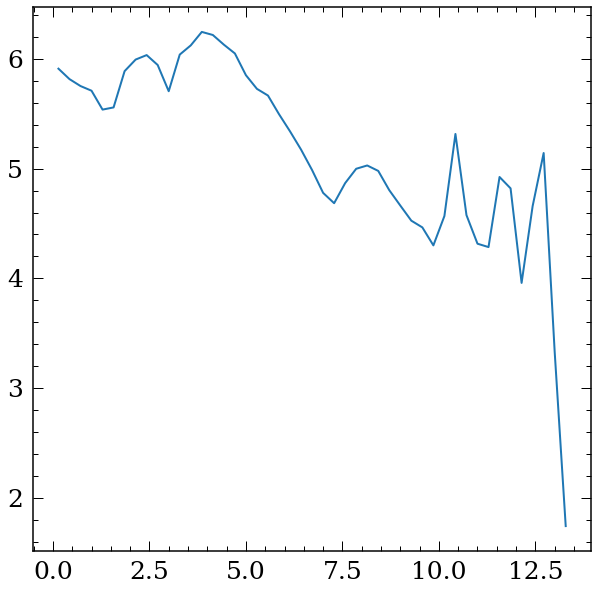

In [622]:
plt.plot(df['age'], df['disksize'])